In [1]:
import pandas as pd
import ast
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np
import re
from mpl_toolkits.mplot3d import Axes3D
from astroquery.esa.jwst import Jwst
from astropy.coordinates import SkyCoord
import astropy.units as u
import sys
import os
import textwrap

## Utility Functions

In [2]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
def compute_mean(sn_list_str):
    try:
        # Remove square brackets and split the string by commas
        sn_list = sn_list_str.strip("[]").replace("'", "").split(',')
        # Convert the list of strings to floats
        sn_list = [float(num) for num in sn_list]
        # Calculate and return the mean
        return sum(sn_list) / len(sn_list) if sn_list else None
    except (ValueError, TypeError):
        return None  # Return None if there's an issue with conversion

In [4]:
def extract_filter_number(filter_value):
        match = re.search(r'F(\d+)W', filter_value)
        return int(match.group(1)) if match else None

In [5]:
def convert_ra_dec_to_ecliptic(ra, dec):
    #Convert RA and Dec (ICRS) to ecliptic latitude and longitude.
    
    # Create a SkyCoord object in ICRS frame
    sky_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    
    # Convert to ecliptic coordinates
    ecliptic_coord = sky_coord.barycentrictrueecliptic
    
    # Return ecliptic longitude and latitude
    return ecliptic_coord.lon.deg, ecliptic_coord.lat.deg

In [6]:
def is_within_ecliptic_range(ra, dec, ecliptic_lat_range):
    #Check if a given RA/Dec is within a certain ecliptic latitude range.

    ecl_lon, ecl_lat = convert_ra_dec_to_ecliptic(ra, dec)
    
    return ecliptic_lat_range[0] <= ecl_lat <= ecliptic_lat_range[1]

In [7]:
def asteroid_jpl_charactoristics(asteroid_name):
    """Collected Manually"""
    #orbital classification classes
    #MB = Main Belt Asteroid
    #IMB = Inner Main Belt Asteroid
    #OMB = Outer Main Belt Asteroid
    #JT = Jupiter Trojan
    #ANEA = Apollo Near Earth Asteroid
    #TNO = TransNeptunian Object
    #C = Centaur
    
    #Diameter estimates from JPL (km)
    #Geometric Albedo estimates from JPL
    
    short_form_dict = {
        'MB':   'Main-Belt Asteroid',
        'JT':   'Jupiter Trojan',
        'IMB':  'Inner Main-Belt Asteroid',
        'ANEA': 'Apollo Near Earth Asteroid',
        'OMB':  'Outer Main-Belt Asteroid',
        'TNO':  'TransNeptunian Object',
        'C':    'Centaur'
    }
        
    
    
    asteroid_params_dict = {'2002 CZ164': ['MB','NA','NA'],
                            '2010 SE55' : ['MB','NA','NA'],
                            '2004 XF41' : ['MB','NA','NA'],
                            '1997 RB1'  : ['MB','3.028','0.305'],
                            '2019 QB44' : ['JT','NA','NA'],
                            '2005 RZ61' : ['MB','NA','NA'],
                            '2008 SX186': ['MB','NA','NA'],
                            '2014 YE88' : ['IMB','NA','NA'],
                            '2008 WE86' : ['MB','NA','NA'],
                            '1999 XY157': ['MB','3.743','0.289'],
                            '2020 KH20' : ['MB','NA','NA'],
                            '2018 HP10' : ['MB','NA','NA'],
                            '2022 WQ19' : ['MB','NA','NA'],
                            '2000 SK247': ['MB','NA','NA'],
                            '2002 UO25' : ['MB','NA','NA'],
                            '2018 AK52' : ['MB','NA','NA'],
                            '2020 OY111': ['MB','NA','NA'],
                            '2012 JS11' : ['ANEA','NA','NA'],
                            '2020 SA57' : ['MB','NA','NA'],
                            '2017 UA86' : ['MB','NA','NA'],
                            '2020 RS115': ['OMB','NA','NA'],
                            '2011 UZ194': ['MB','NA','NA'],
                            '2016 QG127': ['MB','NA','NA'],
                            '1988 RM5'  : ['MB','NA','NA'],
                            '2008 WX'   : ['MB','NA','NA'],
                            '2008 YF34' : ['MB','NA','NA'],
                            '2001 TK17' : ['MB','NA','NA'],
                            '2022 WJ22' : ['MB','NA','NA'],
                            '2021 UE8'  : ['IMB','NA','NA'],
                            '2002 FT2'  : ['MB','6.116','0.068'],
                            '2010 RD101': ['MB','NA','NA'],
                            '2014 DZ80' : ['MB','NA','NA'],
                            '2015 XK95' : ['MB','NA','NA'],
                            '2012 VG116': ['MB','NA','NA'],
                            '2012 SJ16' : ['MB','NA','NA'],
                            '2007 XR66' : ['MB','NA','NA'],
                            '1999 NP39' : ['MB','4.367','0.093'],
                            '1999 XZ93' : ['MB','4.575','0.368'],
                            '1998 BC1'  : ['MB','15.712','0.082'],
                            '2003 EL61' : ['TNO','NA','NA'],
                            '2001 QO160': ['MB','NA','NA'],
                            '2006 DZ86' : ['MB','NA','NA'],
                            '1964 VY'   : ['MB','4.408','0.301'],
                            '2008 EG37' : ['MB','NA','NA'],
                            '1998 QM37' : ['MB','NA','NA'],
                            '2000 WR106': ['TNO','900','0.07'],
                            '2017 PN6': ['MB','NA','NA'],
                            '2016 GT196': ['MB','NA','NA'],
                            '1996 YP': ['MB','NA','NA'],
                            '2001 VF31': ['MB','NA','NA'],
                            '2013 AX137': ['MB','NA','NA'],
                            '2023 RK160': ['MB','NA','NA'],
                            '2003 AB55': ['MB','2.910','0.052'],
                            '2003 QP78': ['MB','2.355','0.046'],
                            '2016 WY66': ['MB','NA','NA'],
                            '2011 BN173': ['MB','NA','NA'],
                            '2023 EL1': ['ANEA','NA','NA'],
                            '2011 RK8': ['MB','NA','NA'],
                            '2008 SV190': ['MB','NA','NA'],
                            '1997 CU26': ['C','NA','NA'],
                            '2002 GG166': ['TNO','NA','NA'],
                            '1999 OX3': ['TNO','NA','NA'],
                            '2000 QC243': ['C','187.5','0.05'],
                            '2015 XN511': ['MB','NA','NA'],
                            '2014 WX577': ['MB','NA','NA'],
                            '2005 SH105': ['MB','NA','NA'],
                            '2007 RG378': ['MB','NA','NA'],
                            '2022 QF262': ['MB','NA','NA'],
                            '1996 NA3': ['MB','NA','NA'],
                            '2001 XZ41': ['MB','NA','NA'],
                            '2006 VT137': ['MB','NA','NA'],
                            '2016 RC17' : ['MB','NA','NA'],
                            '2013 LU28' : ['TNO','NA','NA'],
                            '2000 QC243': ['C','187.5','0.05'],
                            '2000 AY94' : ['MB','NA','NA'],
                            '2015 RG201' : ['MB','NA','NA'],
                            '2008 FA55' : ['MB','NA','NA'],
                            '2003 UM107' : ['MB','NA','NA'],
                            '2011 UK16' : ['MB','NA','NA'],
                            '2011 UM4' : ['MB','NA','NA'],
                            'A907 TC' : ['MB','7.249','0.298'],
                            '2008 TW52' : ['MB','NA','NA'],
                            '2006 XD33' : ['MB','NA','NA'],
                            '2014 OQ381' : ['MB','NA','NA'],
                            '2011 BO29' : ['MB','NA','NA'],
                            '2021 VQ25' : ['MB','NA','NA'],
                            '2014 KY44' : ['IMB','NA','NA'],
                            '2007 TN15' : ['MB','NA','NA'],
                            '2000 SQ146' : ['MB','2.387','0.34'],
                            '2002 GD' : ['MB','NA','NA'],
                            '2016 CJ6' : ['MB','NA','NA'],
                            '2014 NH18' : ['MB','NA','NA'],
                            '2014 WG354' : ['MB','NA','NA'] 
                           }
    
    phys_params = asteroid_params_dict.get(asteroid_name, None)
    
    if phys_params is None:
        classification, diameter, albedo = None, None, None
    else:
        classification, diameter, albedo = phys_params
        
    return([short_form_dict.get(classification, None), diameter, albedo])

In [8]:
def class_to_color(classification):
    class2color_dict = {
        'Main-Belt Asteroid':'tab:blue',
        'Jupiter Trojan':'tab:orange',
        'Inner Main-Belt Asteroid':'tab:green',
        'Apollo Near Earth Asteroid':'tab:red',
        'Outer Main-Belt Asteroid':'tab:purple',
        'TransNeptunian Object':'tab:brown',
        'Centaur': 'tab:pink'
    }
    
    color_str = class2color_dict.get(classification, None)
    
    return(color_str)
    

## Determine Asteroid Frequency in Archive and within an Ecliptic Range

In [9]:
def totalObservationCount(Username, Password, calLevel, moving, prop_start, prop_end, eclipticCheck = False):
    with HiddenPrints():
        #Cosmos Account Credentials
        Jwst.login(user=Username, password=Password)

        queryTopics = ['proposal_id', 'position_bounds_spoly']
        
        if moving == 2:
            queryFilters = [f'jwst.archive.calibrationlevel = {calLevel}', f"jwst.archive.dataproducttype = 'image'", f"jwst.archive.proposal_id<='{prop_end}'", f"jwst.archive.proposal_id>='{prop_start}'", f"jwst.archive.instrument_name='MIRI/IMAGE'"]

        else:
            queryFilters = [f'jwst.archive.calibrationlevel = {calLevel}', f'jwst.archive.target_moving={moving}', f"jwst.archive.dataproducttype = 'image'", f"jwst.archive.proposal_id<='{prop_end}'", f"jwst.archive.proposal_id>='{prop_start}'", f"jwst.archive.instrument_name='MIRI/IMAGE'"]

        #Setting up constraints and filters for data selected for the CSV
        readout_string = ','.join(queryTopics)
        filter_string = ' AND '.join(queryFilters)
        query_string = f"SELECT {readout_string} FROM jwst.archive WHERE ({filter_string})"

        #pull data formatted by the display amount, volume and filter 
        job = Jwst.launch_job(query_string, async_job=True)
        job_id = job.jobid
        result = job.get_results()
        pandas = result.to_pandas()

    #sort the dataframe by the proposal ID
    df = pandas.sort_values(by=['proposal_id'])
    df.reset_index(inplace=True, drop=True)
    archiveDict = df.to_dict("records")

    propList = [x['proposal_id'] for x in archiveDict]
    
    uniqueProposalTotal = df['proposal_id'].nunique()
    
    if eclipticCheck:
        polygons = [str(x['position_bounds_spoly']).replace('Polygon ', '') for x in archiveDict]
        raList  = [x.split()[::2] for x in polygons] 
        decList = [x.split()[1::2] for x in polygons] 
        
        inEcliptic = []
        
        for raVals, decVals in zip(raList, decList):
            raNums = [float(x) for x in raVals]
            decNums = [float(x) for x in decVals]
            
            ra = np.mean(raNums)
            dec = np.mean(decNums)
            
            inEcliptic.append(is_within_ecliptic_range(ra, dec, ecliptic_lat_range=(-1*float(eclipticCheck), float(eclipticCheck))))
                              
        total_observations = len(inEcliptic)
        in_range_count = sum(inEcliptic)
        
        return(len(propList), uniqueProposalTotal, in_range_count)
     
    else:
        return(len(propList), uniqueProposalTotal)

In [10]:
def AsteroidObsFrequency(DF_1,prop_start, prop_end):
    #determine the amount of asteroid obervations in the previous CSV

    #check for the total amount of rows in the dataframe
    totalRowCount = len(DF_1)
    
    #Find all rows that contain a '[' which indicates an asteroid was found
    asteroidRowsTotal = DF_1['Asteroids'].apply(lambda x: isinstance(x, str) and '[' in x).sum()
    
    #asteroids that actually have data
    asteroidRowsUsable = DF_1['Asteroids'].apply(lambda x: isinstance(x, str) and '[' in x and '*' not in x).sum()
    
    #asteroid observations where the data could not be rcovered
    asteroidsRowUnusable = DF_1['Asteroids'].apply(lambda x: isinstance(x, str) and '[' in x and '*' in x).sum()

    #find the unique proposals
    uniqueProposalTotal = DF_1['Proposal'].nunique()
    
    return(totalRowCount, asteroidRowsTotal, asteroidRowsUsable, asteroidsRowUnusable, uniqueProposalTotal)

In [11]:
def AsteroidCountFrequency(DF, ecliptic_range):
    
    #generate a dictionary containing each asteroid name and the amount of times they are repeated
    asteroidCountDict = {}
    
    inEcliptic = []
    
    # Iterate through the DataFrame
    for asteroidString, positionString in zip(DF['Asteroids'], DF['Polygon']):
        if pd.notna(asteroidString) and '[' in asteroidString:  # Check if the value is not NaN
            
            # Remove the brackets and split by comma, then clean each element
            asteroidList = asteroidString.strip('[]').replace("'", "").split(',')
            positions = positionString.replace('Polygon ', '').split()
            ra  = np.mean([float(x) for x in positions[::2]])
            dec = np.mean([float(x) for x in positions[1::2]]) 

            inEcliptic.append(is_within_ecliptic_range(ra, dec, ecliptic_lat_range=(-1*ecliptic_range, ecliptic_range)))
            
            # Update the count for each asteroid in the list
            for asteroid in asteroidList:
                asteroid = asteroid.strip()  # Remove extra spaces
                if asteroid:  # Ensure it's not an empty string
                    if asteroid in asteroidCountDict:
                        asteroidCountDict[asteroid] += 1  # Increment count if already present
                    else:
                        asteroidCountDict[asteroid] = 1  # Initialize count if not present

    total_observations = len(inEcliptic)
    in_range_count = sum(inEcliptic)
    # Sort the dictionary by count in decreasing order and return it
    return (dict(sorted(asteroidCountDict.items(), key=lambda x: x[1], reverse=True)), in_range_count)

## Filter DICT for various Asteroid Energy Bandpass

In [12]:
def AsteroidFilters(DF, asteroidCountDict):
    # Initialize a dictionary to store unique filters in a list (to be sorted later)
    asteroidFilterdict = {}

    # Iterate through the initial DataFrame 
    for i, row in DF.iterrows():
        asteroidString = row['Asteroids']
        filterString = row['Filter']

        if pd.notna(asteroidString) and '[' in asteroidString:  # Check if 'Asteroids' is not NaN
            # Remove brackets and split by comma, then clean each element
            asteroidList = asteroidString.strip('[]').replace("'", "").split(', ')
            
            # Process each asteroid in the row
            for asteroid in asteroidList:
                asteroid = asteroid.strip()  # Clean spaces
                
                if asteroid:  # Ensure it's not an empty string
                    if asteroid not in asteroidFilterdict:
                        # Initialize a list if the asteroid is not in the dictionary yet
                        asteroidFilterdict[asteroid] = []
                    
                    # Add the filter to the list for this asteroid (only if it's not already there)
                    if filterString not in asteroidFilterdict[asteroid]:
                        asteroidFilterdict[asteroid].append(filterString)

    # Sort the filters for each asteroid and maintain the original asteroid order from asteroid_count_dict
    sortedAsteroidFilterDict = {}
    for asteroid in asteroidCountDict:
        if asteroid in asteroidFilterdict:
            # Sort the filters in increasing order
            sortedAsteroidFilterDict[asteroid] = sorted(asteroidFilterdict[asteroid], key=lambda x: int(re.findall(r'\d+', x)[0]), reverse=True)

    return sortedAsteroidFilterDict

## Filter DICT for various Asteroid Energy Bandpass

In [13]:
def AsteroidProposals(DF, asteroidCountDict):
    
    # Dictionary to store asteroid data
    AsteroidPropDict = {}
    
    # Iterate through the rows of the DataFrame
    for index, row in DF.iterrows():
        asteroids = row['Asteroids']
        
        # Check if the 'Asteroids' column contains a list (i.e., contains '[')
        if pd.notna(asteroids) and '[' in asteroids:
            # Extract the list of asteroid names (assuming it's in the form of a string list)
            asteroids_list = asteroids.strip('[]').replace("'", "").split(', ')
            
            # Get the filter and proposal from the current row
            proposal_used = row['Proposal']
            
            # Iterate over each asteroid in the list
            for asteroid in asteroids_list:
                if asteroid not in AsteroidPropDict:
                    # Initialize data for this asteroid
                    AsteroidPropDict[asteroid] = []
                    #{'proposals': set([proposal_used])}
                if str(proposal_used) not in AsteroidPropDict[asteroid]:
                    # Update the count, filters, and proposals for the asteroid
                    AsteroidPropDict[asteroid].append(str(proposal_used))
                    #AsteroidPropDict[asteroid]['proposals'].add(proposal_used)
    
    sortedAsteroidPropDict = {}
    for asteroid in asteroidCountDict:
        if asteroid in AsteroidPropDict:
            # Sort the filters in increasing order
            sortedAsteroidPropDict[asteroid] = sorted(AsteroidPropDict[asteroid])
            
    return(sortedAsteroidPropDict)

## Filter DICT for various Asteroid Time Span

In [14]:
def AsteroidTimeSpan(DF, asteroidCountDict):
    # Dictionary to store asteroid data
    AsteroidTimeDict = {}

    # Iterate through the CSV rows
    for index, row in DF.iterrows():
        asteroids = row['Asteroids']

        # Check if the 'Asteroids' column contains a list of asteroids
        if pd.notna(asteroids) and '[' in asteroids:
            # Extract the list of asteroid names (assuming the asteroids are in the form of a string list)
            asteroidList = asteroids.strip('[]').replace("'", "").split(', ')

            # Parse the time from 'Exp Start' column
            exp_start_time = datetime.strptime(row['Exp Start'], '%Y-%m-%d %H:%M:%S.%f')

            # For each asteroid, update the count, earliest, and latest appearance
            for asteroid in asteroidList:
                if asteroid not in AsteroidTimeDict:
                    # Initialize the data for this asteroid
                    AsteroidTimeDict[asteroid] = {
                        'earliest_time': exp_start_time,
                        'latest_time': exp_start_time
                    }
                else:
                    # check if the time is earlier or later
                    if exp_start_time < AsteroidTimeDict[asteroid]['earliest_time']:
                        AsteroidTimeDict[asteroid]['earliest_time'] = exp_start_time
                    if exp_start_time > AsteroidTimeDict[asteroid]['latest_time']:
                        AsteroidTimeDict[asteroid]['latest_time'] = exp_start_time

    # Prepare the final result
    AsteroidTimediffDict = {}
    
    for asteroid, times in AsteroidTimeDict.items():
        earliest_time = times['earliest_time']
        latest_time = times['latest_time']     
            
        # Calculate the time difference (delta)
        total_time_delta = latest_time - earliest_time
            
        # Store the formatted results in a dictionary
        AsteroidTimediffDict[asteroid] = [
            earliest_time.strftime('%Y-%m-%d %H:%M:%S'),
            latest_time.strftime('%Y-%m-%d %H:%M:%S'),
            str(total_time_delta).split('.')[0]  # Ignore microseconds
        ]
    
    # Sort the filters for each asteroid and maintain the original asteroid order from asteroid_count_dict
    sortedAsteroidTimeDict = {}
    for asteroid in asteroidCountDict:
        if asteroid in AsteroidTimediffDict:
            # Sort the filters in increasing order
            sortedAsteroidTimeDict[asteroid] = (AsteroidTimediffDict[asteroid])

    return(sortedAsteroidTimeDict)

## Filter DICT for various Asteroid Classification

In [15]:
def asteroidClassification(asteroidCountDict):
    asteroidClassDict = {key: asteroid_jpl_charactoristics(key) for key in asteroidCountDict}
    return(asteroidClassDict)

## Combine the Dictionaries into a Dataframe

In [16]:
def combineDicts(D1,D2,D3,D4,D5):
    df = pd.DataFrame({
    'Asteroid': list(D1.keys()),
    'Counts': list(D1.values()),
    'Filters': list(D2.values()),
    'Proposals': list(D3.values())
    })

    # Expand the fourth dictionary (which contains lists)
    df[['Earliest Obs', 'Latest Obs', 'Time Diff']] = pd.DataFrame(D4).T.values
    
    df[['Classification', 'Diameter', 'Albedo']] = pd.DataFrame(D5).T.values

    return(df)

## Plots

In [17]:
def plotAsteroidCount(combinedDF, path):
    #plot the amount of asteroids
    
    # Assign colors based on the custom function
    bar_colors = [class_to_color(classification) for classification in combinedDF['Classification']]


    # Create a bar plot
    plt.figure(figsize=(14, 6))
    bars = plt.bar(combinedDF['Asteroid'], combinedDF['Counts'], color=bar_colors, edgecolor='black', zorder = 2)

    # Add titles and labels
    plt.title(f'Observations of Each {len(combinedDF["Asteroid"])} Unique Asteroids', fontsize=14)
    plt.xlabel('Asteroids', fontsize=12)
    plt.ylabel('Observations', fontsize=12)
    
    unique_classifications = combinedDF['Classification'].unique()
    legend_handles = [plt.Line2D([0], [0], color=class_to_color(classification), lw=10) for classification in unique_classifications]

    plt.legend(
        legend_handles,
        unique_classifications,
        title='Classifications',
        loc='upper right',  # Adjust legend position as needed
        fontsize=10,
        title_fontproperties={"weight": "bold"}
        
    )


    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    #plt.tick_params(axis='x', pad=10) 
    
    plt.xlim(-0.5,len(combinedDF['Asteroid'])-0.5)

    # Show the plot
    plt.tight_layout()  # Adjust layout to make room for rotated x labels
    plt.grid(axis = 'y', c='k', alpha = 0.5, zorder = 1)
    plt.savefig(f'{path}AsteroidCount.png')
    plt.show()

In [18]:
def plotfilters(combinedDF,path):
    # Count occurrences of each filter
    filter_counts = combinedDF['Filter'].value_counts()

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(filter_counts.index, filter_counts.values, color='tab:blue', edgecolor='black', zorder = 2)

    # Add titles and labels
    plt.title('Asteroids Observed in each Filter', fontsize=14)
    plt.xlabel('Filters', fontsize=12)
    plt.ylabel('Asteroids', fontsize=12)

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    plt.grid(axis = 'y', alpha = 0.5, c = 'k', zorder = 1)
    # Show the plot
    plt.tight_layout()  # Adjust layout to make room for rotated x labels
    plt.savefig(f'{path}AsteroidFilters.png')
    plt.show()

In [34]:
def plotTimespan(df_without_star, combinedDF, path):
    # Make a copy of the original DataFrame if needed
    df_without_star = df_without_star.copy()
        
    # Convert to datetime variables 
    df_without_star['Exp Start'] = pd.to_datetime(df_without_star['Exp Start'], format='%Y-%m-%d %H:%M:%S.%f')
    
    # Create a new column for the 'Month-Year' for binning
    df_without_star['Month-Year'] = df_without_star['Exp Start'].dt.to_period('M')
    
    # Extract the proposal range based on the first digit of the 'Proposal' column
    df_without_star['Proposal Range'] = df_without_star['Proposal'].astype(str).str[0].map({
        '1': '1000-2000',
        '2': '2000-3000',
        '3': '3000-4000',
        '4': '4000-5000',
        '5': '5000-6000'
    })

    # Remove rows with invalid Proposal values (not starting with 1-5)
    df_without_star = df_without_star.dropna(subset=['Proposal Range'])
    
    # Resample to monthly periods
    df_without_star['Monthly'] = df_without_star['Exp Start'].dt.to_period('M')  # Monthly periods
    
    # Count the number of entries per 'Monthly' and 'Proposal Range'
    grouped = df_without_star.groupby(['Monthly', 'Proposal Range']).size().unstack(fill_value=0)
    
    # Ensure proper sorting by Monthly and include all monthly ranges
    all_months = pd.period_range(start=grouped.index.min(), end=grouped.index.max(), freq='M')
    grouped = grouped.reindex(all_months, fill_value=0)
    
    # Prepare for stacked bar chart
    months = grouped.index.astype(str)  # Convert PeriodIndex to string for plotting
    ranges = grouped.columns  # Proposal ranges
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']  # Color for each range
    
    # Plotting
    plt.figure(figsize=(12, 8))
    bottom_values = [0] * len(months)  # Initialize the bottom for stacking
    
    for i, proposal_range in enumerate(ranges):
        plt.bar(months, grouped[proposal_range], bottom=bottom_values, color=colors[i], 
                edgecolor='black', label=proposal_range, zorder=2)
        # Update the bottom values for stacking
        bottom_values += grouped[proposal_range]
    
    # Find time span for the title
    combinedDF = combinedDF.copy()
    combinedDF['Earliest Obs'] = pd.to_datetime(combinedDF['Earliest Obs'], format='%Y-%m-%d %H:%M:%S')
    earliest_date = combinedDF['Earliest Obs'].min()
    latest_date = combinedDF['Earliest Obs'].max()
    time_span = latest_date - earliest_date
    
    # Add title and labels
    plt.title(f'Number of Asteroid Containing Observations per Month (Spans: {time_span})')
    plt.xlabel('Monthly Period')
    plt.ylabel('Number of Observations')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Proposal Range')
    plt.tight_layout()
    max_height = grouped.sum(axis=1).max()
    y_margin = max_height * 0.1  # Adjust the percentage as needed
    plt.ylim(0, max_height + y_margin)
    
    # Add gridlines for clarity
    plt.grid(axis='y', color='k', alpha=0.5, zorder=1)
    
    # Save the plot
    plt.savefig(f'{path}AsteroidTime.png')
    
    # Show the plot
    plt.show()

In [42]:
def SNfilters(df_without_star,path):  
    # Make a copy of the original DataFrame if needed
    df_without_star = df_without_star.copy()
    
    df_without_star = df_without_star[df_without_star['Asteroids'].str.contains(r'\[', na=False)]

    # Apply the function to the 'S/N' column to calculate the mean for each row using .loc
    df_without_star.loc[:, 'S/N_mean'] = df_without_star['S/N'].apply(compute_mean)

    # Add a new column 'FilterNumber' by extracting the numeric part of the 'Filter' values
    df_without_star.loc[:, 'FilterNumber'] = df_without_star['Filter'].apply(extract_filter_number)

    # Now group by 'Filter' and 'FilterNumber' and calculate the average and count
    grouped_data = df_without_star.groupby(['Filter', 'FilterNumber']).agg(
        avg_sn=('S/N_mean', 'mean'),   # Calculate average of the row-level means
        count=('S/N_mean', 'count')    # Count the number of non-null entries
    ).reset_index()

    # Sort the grouped data by the 'FilterNumber' column
    grouped_data = grouped_data.sort_values('avg_sn', ascending=False)

    # Plot a bar chart for average 'S/N' by 'Filter'
    plt.figure(figsize=(10, 6))
    bars = plt.bar(grouped_data['Filter'], grouped_data['avg_sn'], color='tab:blue', edgecolor='black', zorder = 2)

    maxHeight = 0
    # Add the count of entries above each bar
    for bar, count in zip(bars, grouped_data['count']):
        yval = bar.get_height()
        if yval > maxHeight:
            maxHeight = yval
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{count}', ha='center', va='bottom',fontsize=13)

    # Add titles and labels
    plt.title('Average S/N by Filter')
    plt.xlabel('Bandpass Filter')
    plt.ylabel('Average S/N')
    
    plt.xticks(rotation=45, fontsize=10) 

    #plt.hlines(1,-1,len(bars), color = 'gray' , linestyle = 'dashed', alpha = 0.8)
    #plt.xlim(-0.5, len(bars) -0.5)
    
    plt.grid(axis='y', c = 'k', alpha = 0.5, zorder = 1)
    plt.ylim(1,(10/9)*maxHeight)
    plt.text(len(grouped_data['Filter']) - 1.7, (10/9)*maxHeight*0.92, '# : Amount of observations \n     in a given filter', ha='center', va='bottom')
    #plt.legend(handles=[],labels=['# = Amount of observations in a given filter'])
    # Show the plot
    plt.savefig(f'{path}AsteroidS2N.png')
    plt.show()

In [43]:
def AsteroidPosition(DF, path,eclipticRange, plot= True):
    
    # Initialize lists to store RA and DEC averages for the plot
    ra_averages = []
    dec_averages = []
    moving =[]
    in10range = []

    # Iterate over the rows of the CSV
    for index, row in DF.iterrows():
        # Filter rows where 'Asteroids' contains '['
        if pd.notna(row['Asteroids']) and '[' in row['Asteroids'] and not '*' in row['Asteroids']:
            polygon = row['Polygon']

            # Extract the numbers after the word 'Polygon'
            polygon_values = list(map(float, polygon.replace('Polygon', '').split()))

            # Group values into two lists: X (RA) and Y (DEC)
            ra_values = polygon_values[::2]  # Every other value starting from index 0 (X values)
            dec_values = polygon_values[1::2]  # Every other value starting from index 1 (Y values)

            # Calculate the averages for RA and DEC
            ra_avg = np.mean(ra_values)
            dec_avg = np.mean(dec_values)

            # Store these averages for plotting
            ra_averages.append(ra_avg)
            dec_averages.append(dec_avg)

            moving.append(row['Moving'])
            
            in10range.append(is_within_ecliptic_range(ra_avg, dec_avg, ecliptic_lat_range=(-1*eclipticRange, eclipticRange)))
            
                

    # Convert RA and DEC to radians for astronomical plotting
    ra_radians = np.radians(ra_averages)
    dec_radians = np.radians(dec_averages)

    if plot:
        colors = ['tab:blue' if move == 'No' else 'tab:orange' for move in moving]
        edge_colors = ['tab:red' if is_true else 'none' for is_true in in10range]
        linewidths = [0.8 if condition else 0 for condition in in10range]

        ### Plot 1: 2D Cartesian Plot (RA vs DEC) with the full ecliptic line
        plt.figure(figsize=(8, 6))
        plt.scatter(ra_averages, dec_averages, edgecolor = edge_colors, linewidths = linewidths, c=colors, s=30, alpha=0.6, zorder = 3)
        plt.scatter([],[],c='tab:blue', s=20, label = 'Non-Moving Targets')
        if 'Yes' in moving:
            plt.scatter([],[],c='tab:orange', s=20, label = 'Moving Targets') 
        plt.scatter([],[],edgecolor= 'tab:red',s=20, facecolors='none', label = 'Ecliptic Range')

        # Plot the full ecliptic as a sine wave spanning 0 to 360 degrees RA
        ecliptic_ra = np.linspace(0, 360, 1000)
        ecliptic_dec = 23.44 * np.sin(np.radians(ecliptic_ra))  # Earth's axial tilt (23.44 degrees)
        #ecliptic_upper = 23.44 * np.sin(np.radians(ecliptic_ra)) + 5
        #ecliptic_lower = 23.44 * np.sin(np.radians(ecliptic_ra)) - 5

        plt.plot(ecliptic_ra, ecliptic_dec, color='tab:red', linestyle='dashed', alpha = 0.5, label='Ecliptic Line', zorder = 2)
        #plt.plot(ecliptic_ra, ecliptic_dec, color='tab:red', linewidth = 40, alpha = 0.3)
        #plt.plot([], [], color='tab:red', linewidth = 30, alpha = 0.3, label='10 Deg, Main-belt Region')

        # Labels and grid
        plt.title('LVL2: Location of Observed Asteroids (RA vs DEC)')
        plt.xlabel('Right Ascension (RA)')
        plt.ylabel('Declination (DEC)')
        plt.grid(True, zorder = 1)
        plt.legend()
        plt.xlim(0, 360)  # Ensure the RA spans the full 0-360 degree range
        #plt.savefig('LVL3_CartesianProjection.png')
        plt.savefig(f'{path}AsteroidLocation2D.png')
        plt.show()
        plt.close()
        
        
        ### Plot the bar graph of the distribution
        distances_to_ecliptic = [i - 23.44 * np.sin(np.radians(j)) for i,j in zip(dec_averages, ra_averages)] 
        
        non_moving_distances = []
        moving_distances = []
        for i in range(len(distances_to_ecliptic)):
            if moving[i] == 'No':
                non_moving_distances.append(distances_to_ecliptic[i])
            else:
                moving_distances.append(distances_to_ecliptic[i])
        
        bins = np.histogram_bin_edges(non_moving_distances, bins=20)
        
        # Plotting the stacked frequency chart
        plt.figure(figsize=(12, 6))

        # Bar plot for non-moving asteroids
        plt.hist(non_moving_distances, bins = bins, color='tab:blue',edgecolor='black',alpha=0.7,label='Non-Moving Targets', zorder = 2)
        plt.hist(moving_distances, bins = bins, color='tab:orange',edgecolor='black',alpha=0.7,label='Moving Targets', zorder = 2)

        
        plt.xlim(bins[0], bins[-1])
        
        # Adding labels and reference line
        plt.axvline(0, color='k', linestyle='dashed', label='Ecliptic Plane', zorder = 3)  # Ecliptic reference line
        plt.grid(zorder = 1)
        plt.xlabel('Distance from Ecliptic (Deg)')
        plt.ylabel('Frequency')
        plt.title('Asteroid Distances from the Ecliptic')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        
        
        ### Plot the bar graph of the distribution stacked
        distances_to_ecliptic = [i - 23.44 * np.sin(np.radians(j)) for i,j in zip(dec_averages, ra_averages)] 
        
        non_moving_distances = []
        moving_distances = []
        for i in range(len(distances_to_ecliptic)):
            if moving[i] == 'No':
                non_moving_distances.append(distances_to_ecliptic[i])
            else:
                moving_distances.append(distances_to_ecliptic[i])
        
        bins = np.histogram_bin_edges(non_moving_distances, bins=20)
        
        # Plotting the stacked frequency chart
        plt.figure(figsize=(12, 6))
        
        # Prepare data for the stacked histogram
        data_to_plot = [non_moving_distances, moving_distances]

        # Plotting the stacked frequency chart
        plt.figure(figsize=(12, 6))

        # Stacked histogram
        plt.hist(data_to_plot, bins=bins, stacked=True, color=['tab:blue', 'tab:orange'], 
                 edgecolor='black', alpha=0.9, label=['Non-Moving Targets', 'Moving Targets'], zorder=2)
        
        
        plt.xlim(bins[0], bins[-1])
        
        # Adding labels and reference line
        plt.axvline(0, color='k', linestyle='dashed', label='Ecliptic Plane', zorder = 3)  # Ecliptic reference line
        plt.grid(zorder = 1)
        plt.xlabel('Distance from Ecliptic (Deg)')
        plt.ylabel('Frequency')
        plt.title('Asteroid Distances from the Ecliptic')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        
        
        
        # Calculate distances from the ecliptic
        distances_to_ecliptic = [i - 23.44 * np.sin(np.radians(j)) for i, j in zip(dec_averages, ra_averages)]
        
        filtered_df = DF[DF['Asteroids'].notna() & DF['Asteroids'].str.contains('\[', na=False) & ~DF['Asteroids'].str.contains('\*', na=False)].reset_index(drop=True)#

        # Group distances by JPL Category
        categories = list(set(filtered_df['JPL Classification']))  # Unique categories in JPL Category column
      
        categories = [cat.strip('[]').strip("'") for cat in categories if ',' not in cat]
        
        category_distances = {cat: [] for cat in categories}
        
        # Populate category distances
        for i, row in filtered_df.iterrows():
            category_ = row['JPL Classification'].strip('[]').replace("'","")
            
            if ', ' in category_:
                cat1, cat2 = category_.split(', ')
                if cat1 in category_distances:
                    category_distances[cat1].append(distances_to_ecliptic[i]) 
                else:
                    print('NO', category_, cat1)
                if cat2 in category_distances:
                    category_distances[cat2].append(distances_to_ecliptic[i])
                else:
                    print('NO', category_, cat2)
                    
            else:
                if category_ in category_distances:
                    category_distances[category_].append(distances_to_ecliptic[i])
                else:
                    print('NO...', category_)
                    

        unwanted_category = 'No Data'  # Replace with the actual category name you want to remove
        if unwanted_category in category_distances:
            del category_distances[unwanted_category]        
        
        
        # Compute the total frequency for each category
        category_frequencies = {cat: np.histogram(data, bins=bins)[0].sum() for cat, data in category_distances.items()}

        # Sort categories by total frequency (most frequent first)
        sorted_categories = sorted(category_distances.items(), key=lambda x: category_frequencies[x[0]], reverse=True)

        # Unpack sorted data for plotting
        sorted_labels, sorted_data = zip(*sorted_categories)

        
        
        # Prepare data for the histogram
        #data_to_plot = [distances for distances in category_distances.values()]
        #category_labels = category_distances.keys()

        
        
        # Plot the stacked histogram
        plt.figure(figsize=(12, 6))
        plt.hist(sorted_data, bins=bins, stacked=True, label=sorted_labels, edgecolor='black', alpha=0.9, zorder=2)

        # Add a reference line at 0 (Ecliptic plane)
        plt.axvline(0, color='k', linestyle='dashed', label='Ecliptic Plane', zorder=3)

        plt.xlim(bins[0], bins[-1])
        
        # Add labels, legend, and grid
        plt.xlabel('Distance from Ecliptic (Deg)')
        plt.ylabel('Frequency')
        plt.title('Asteroid Distances from the Ecliptic by Category')
        plt.grid(zorder=1)
        plt.legend()
        plt.tight_layout()

        # Show the plot
        plt.show()
        
        
        
        
        ### Plot 2: 2D Full-Sky Map (Aitoff Projection)
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='aitoff')

        # Convert RA for Aitoff projection: shift RA by 180 degrees and convert to radians
        ra_radians_aitoff = np.radians(np.array(ra_averages) - 180)  # Shift RA by 180 degrees for Aitoff

        # Plot the asteroid locations on the Aitoff projection
        ax.scatter(ra_radians_aitoff, dec_radians, edgecolor = edge_colors, linewidths = linewidths, c=colors,  s=28, alpha=0.6, zorder = 3)
        plt.scatter([],[],c='tab:blue', s=15, label = 'Non-Moving Targets')

        if 'Yes' in moving:  
            plt.scatter([],[],c='tab:orange', s=15, label = 'Moving Targets')
        plt.scatter([],[],edgecolor= 'tab:red',s=15, facecolors='none', label = 'Within 10 Deg of Ecliptic')

        # Plot the full ecliptic on the Aitoff projection
        ecliptic_ra_aitoff = np.radians(np.linspace(0, 360, 1000) - 180)
        ecliptic_dec_aitoff = np.radians(23.44 * np.sin(np.radians(np.linspace(0, 360, 1000))))

        ax.plot(ecliptic_ra_aitoff, ecliptic_dec_aitoff, color='tab:red', linestyle='dashed', alpha = 0.5, label='Ecliptic Line', zorder = 2)

        # Labels and grid
        ax.set_title('LVL3: Location of Observed Asteroids (Galactic Projection)', pad= 20)
        ax.grid(True, zorder = 1)
        ax.legend()

        #plt.savefig('LVL3_GalacticProjection.png')
        plt.savefig(f'{path}AsteroidLocation3D.png')
        plt.show()
        #plt.close()
    


## Main

In [44]:
def main(Username, Password, csvName, calLevel, movingCheck, prop_start, prop_end, ecliptic_range):
    
    pd.set_option('display.max_rows', None)  
    pd.set_option('display.width', 1000)
    
    path = f'{csvName.split("/")[0]}/'
    
    # Load the CSV file
    df_original = pd.read_csv(csvName)
    
    df_proposal_filtered = df_original[df_original['Proposal'].astype(str).apply(lambda x: x.isdigit() and prop_start <= int(x) <= prop_end)].reset_index(drop=True)
    
    #df_with_star = df[df['Asteroids'].str.contains(r'\*', na=False)]  # DataFrame with rows containing '*'

    # Filter rows where the 'Asteroids' column does not contain '*'
    #df_without_star = df[~df['Asteroids'].str.contains(r'\*', na=False)]  # DataFrame without rows containing '*'
     
    if movingCheck == 'No':
        df_final = df_proposal_filtered[df_proposal_filtered['Moving'] == 'No']
        moving = 0
    
    elif movingCheck == 'Yes':
        df_final = df_proposal_filtered[df_proposal_filtered['Moving'] == 'Yes']
        moving = 1
        
    elif movingCheck == 'Both':
        df_final = df_proposal_filtered
        moving = 2
        
    
    totalObs, uniqueProps, obsInEcliptic =  totalObservationCount(Username, Password, calLevel, moving, prop_start, prop_end, eclipticCheck = ecliptic_range)
    totalRowCount, asteroidRowsTotal, asteroidRowsUsable, asteroidRowsUnusable, uniqueProposalTotal = AsteroidObsFrequency(df_final, prop_start, prop_end)
    
    print(f'The CSV contains a total of {totalRowCount} Observations (rows) from {uniqueProps} unique proposals, of that {asteroidRowsUsable} observations contain usable asteroid information, and {asteroidRowsUnusable} have no Datalabs information\n')
    
    print(f'Within the Proposal Range ({prop_start} - {prop_end}) there are {totalObs} total Level {calLevel} Observations and {obsInEcliptic} Observations within {ecliptic_range} Degrees of the Ecliptic\n')
    
    df_without_star = df_final[~df_final['Asteroids'].str.contains(r'\*', na=False)]  # DataFrame without rows containing '*'
    
    Dict1, eclipticCount = AsteroidCountFrequency(df_without_star, ecliptic_range)
    
    print(f'Within the ecliptic range we have {eclipticCount} Asteroid observations')
    print(f'Combining this with the total amount of observations, we find 1 measurable Asteroid in every {round(float(obsInEcliptic)/float(eclipticCount),2)} Observations')
    
    Dict2 = AsteroidFilters(df_without_star, Dict1)
    Dict3 = AsteroidProposals(df_without_star, Dict1)
    Dict4 = AsteroidTimeSpan(df_without_star, Dict1)
    Dict5 = asteroidClassification(Dict1)

    combinedDF = combineDicts(Dict1,Dict2,Dict3,Dict4,Dict5)

    combinedDF.reset_index(inplace=True, drop=True)
    pd.set_option('display.max_rows', 1000)  
    pd.set_option('display.width', 1000)
    
    print(f'There are a total of {combinedDF["Counts"].sum()} asteroid measurments from {(len(combinedDF))} unique asteroids from {eclipticCount} asteroid containing observations, within ecliptic range {ecliptic_range}')
    
    print(combinedDF)
    
    #Plots
    plotAsteroidCount(combinedDF, path)
    plotfilters(df_without_star, path)
    plotTimespan(df_without_star, combinedDF, path)
    
    if calLevel == 2:
        SNfilters(df_without_star, path)
        
    movingTest = AsteroidPosition(df_without_star, path, ecliptic_range)

The CSV contains a total of 3072 Observations (rows) from 275 unique proposals, of that 441 observations contain usable asteroid information, and 143 have no Datalabs information

Within the Proposal Range (1000 - 5000) there are 30881 total Level 2 Observations and 7730 Observations within 10 Degrees of the Ecliptic

Within the ecliptic range we have 378 Asteroid observations
Combining this with the total amount of observations, we find 1 measurable Asteroid in every 20.45 Observations
There are a total of 481 asteroid measurments from 61 unique asteroids from 378 asteroid containing observations, within ecliptic range 10
      Asteroid  Counts                          Filters Proposals         Earliest Obs           Latest Obs Time Diff              Classification Diameter Albedo
0   2002 CZ164      32                  [F1280W, F770W]    [1802]  2022-07-23 04:17:52  2022-07-23 07:55:18   3:37:25          Main-Belt Asteroid       NA     NA
1    2010 SE55      29          [F1280W, F113

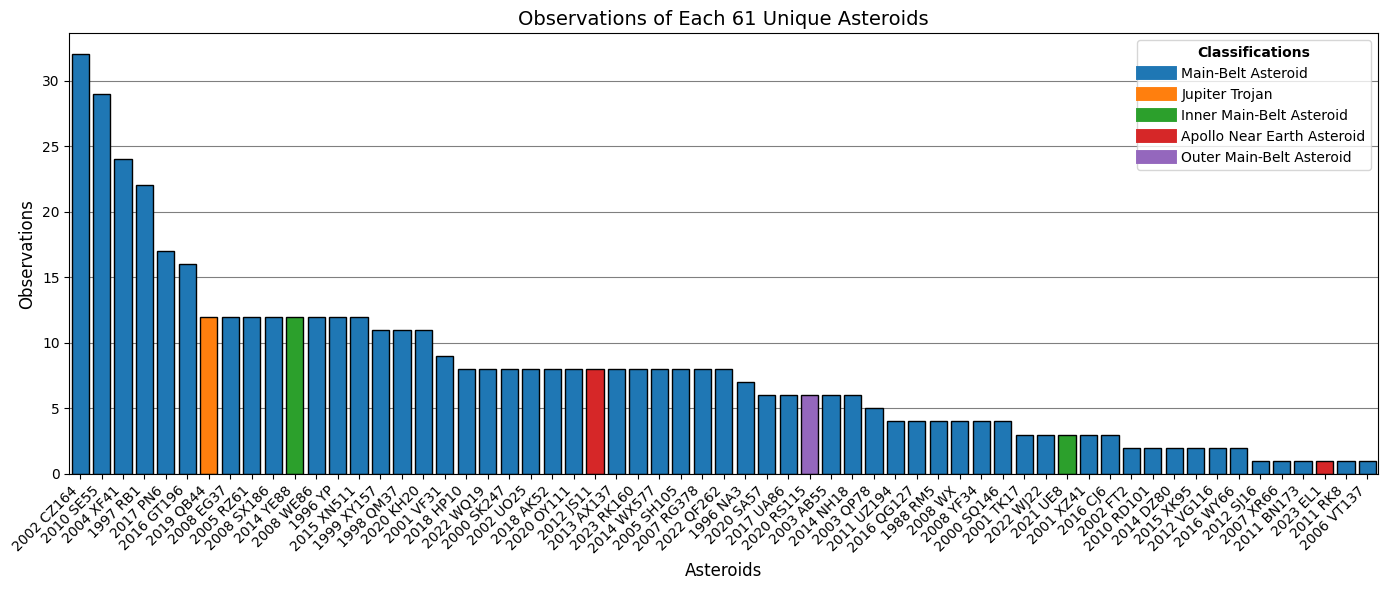

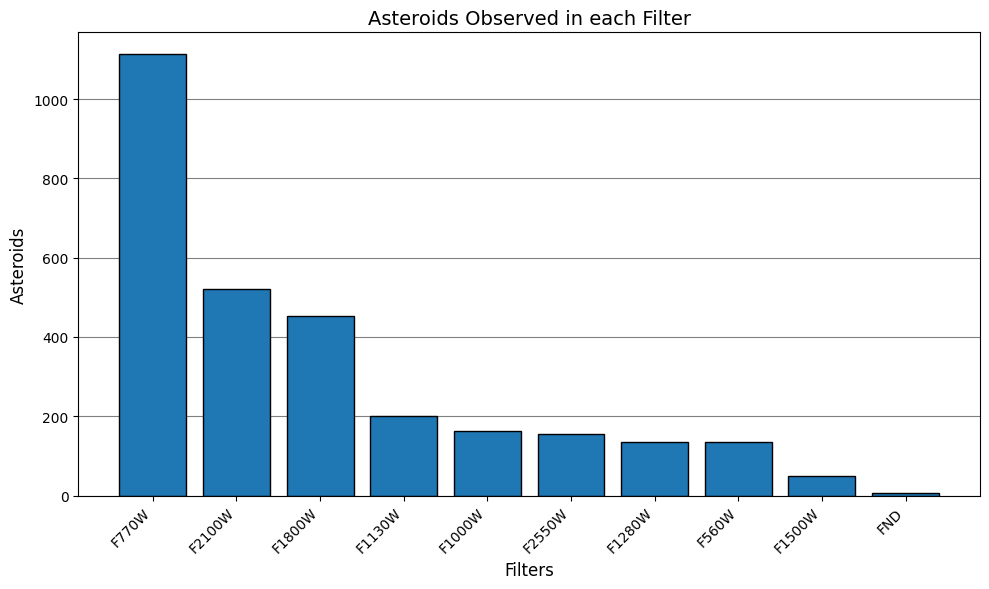

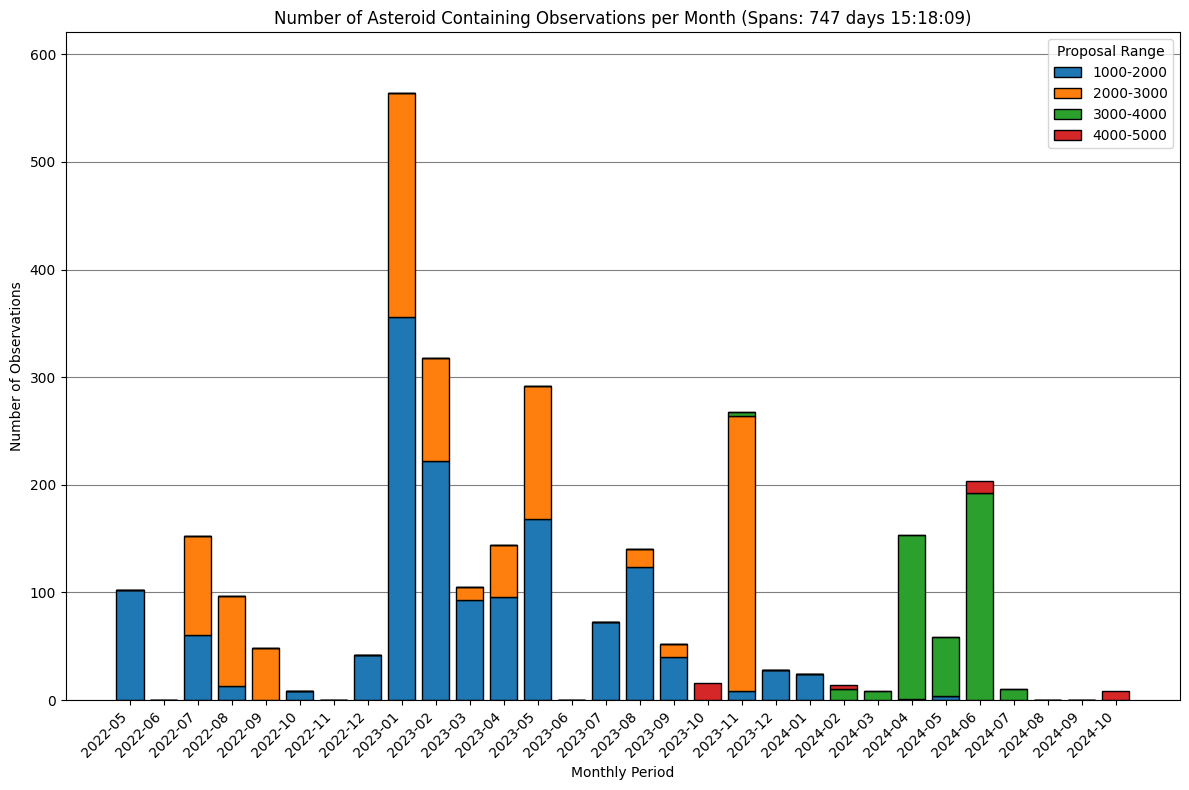

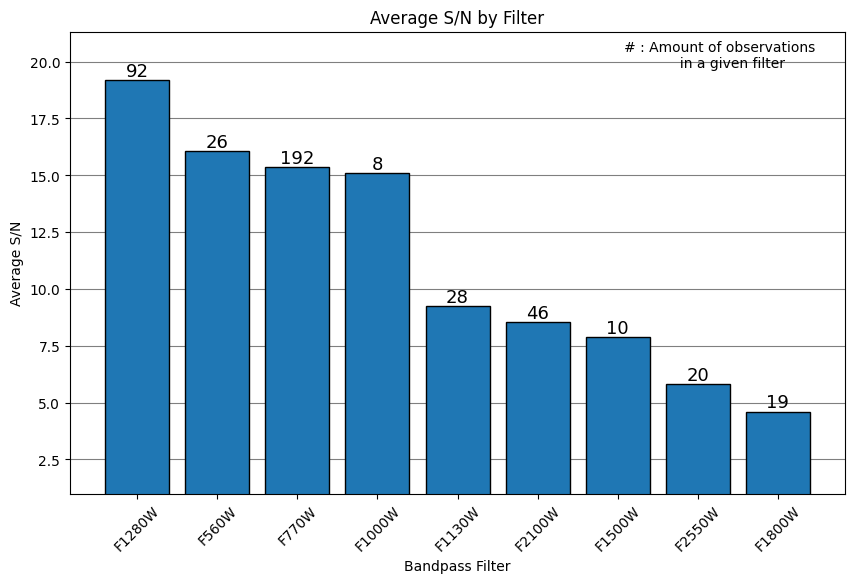

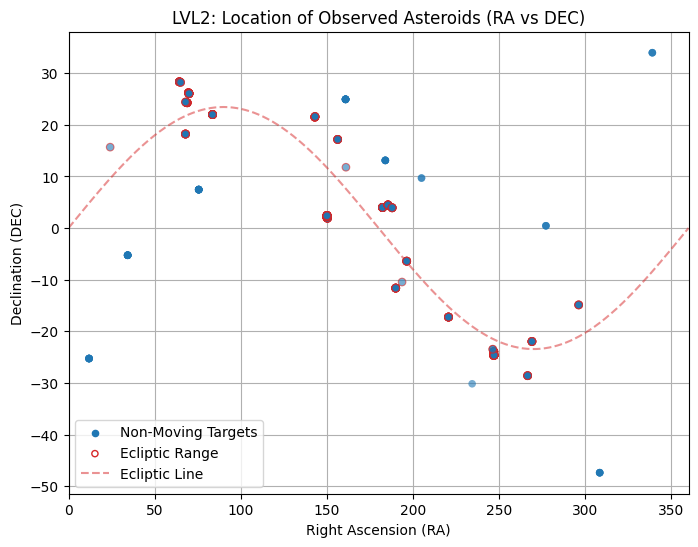

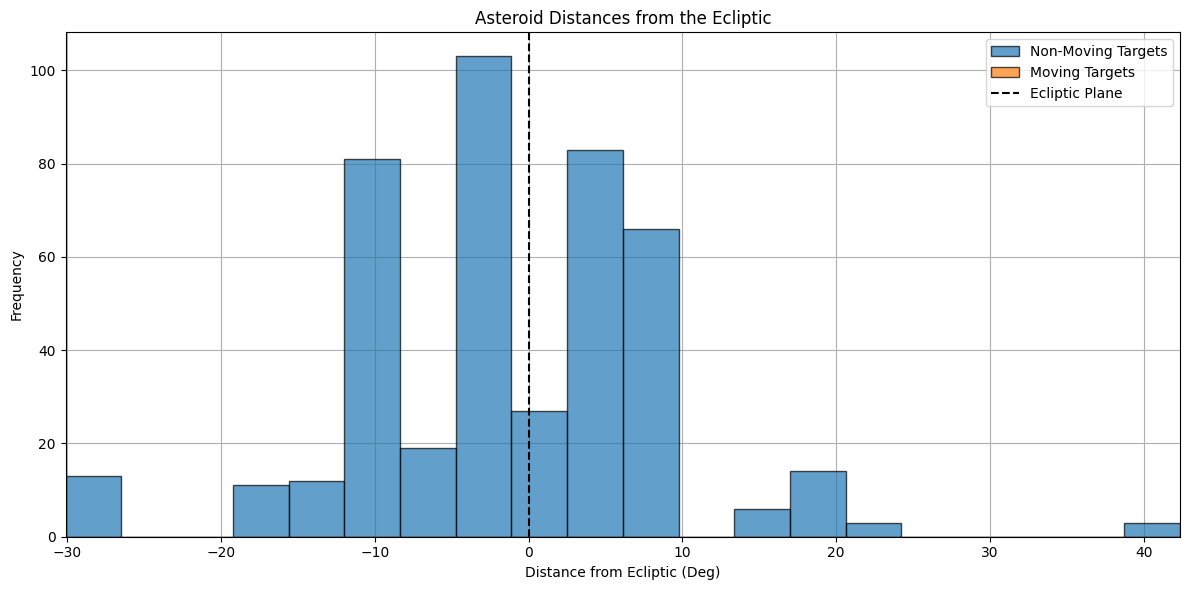

<Figure size 1200x600 with 0 Axes>

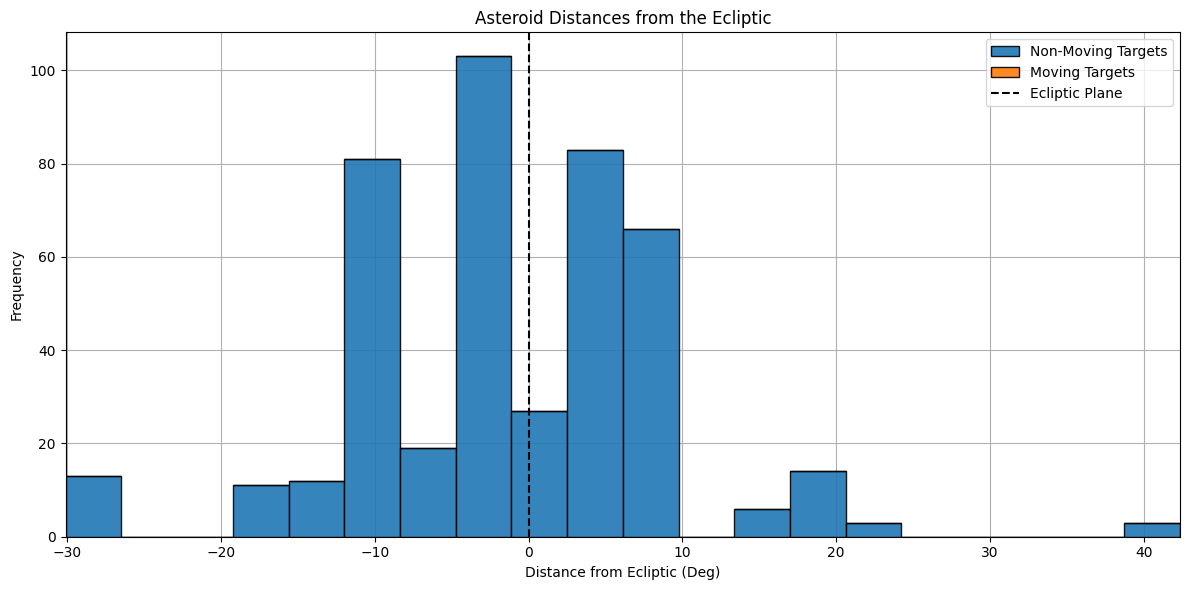

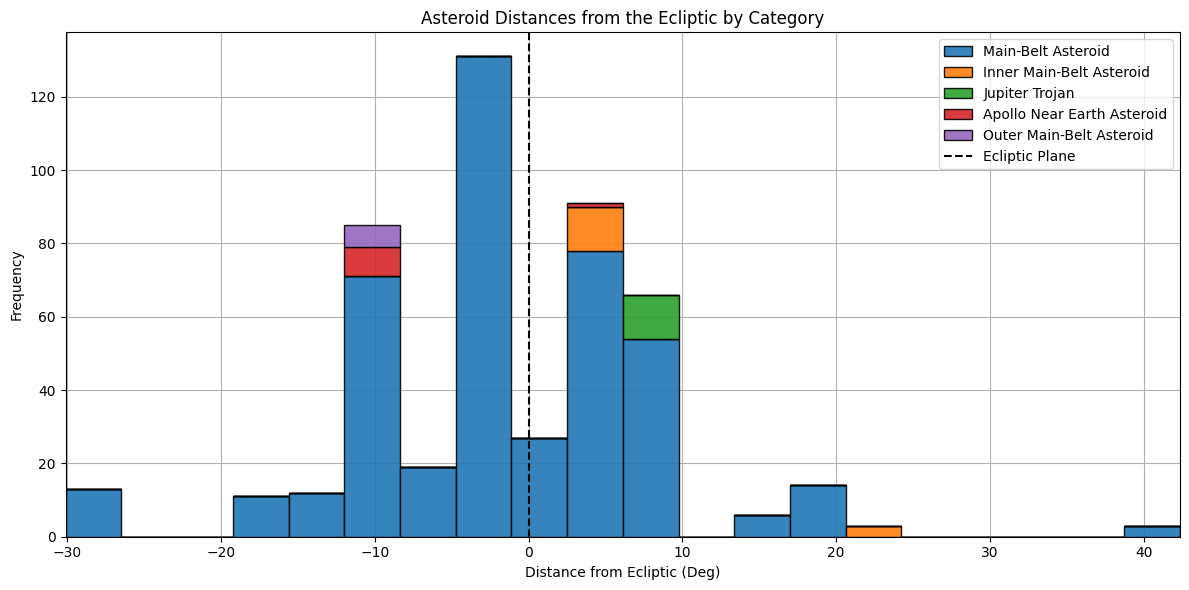

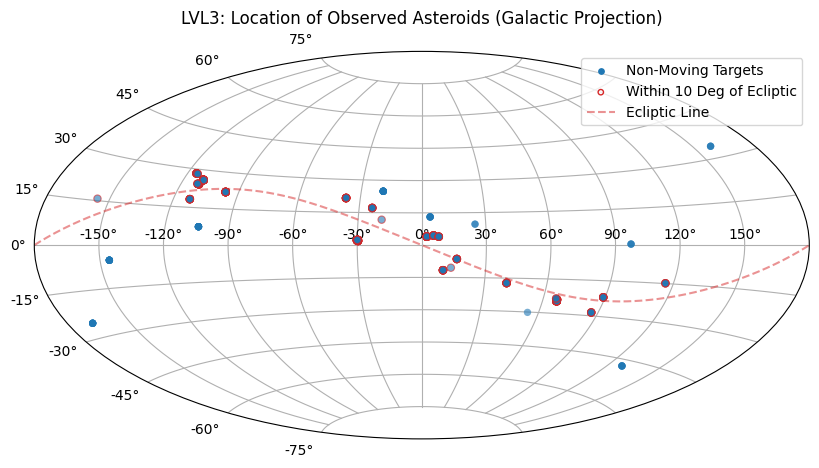

In [48]:
calLevel = 2
movingCheck = 'No'
Username = 'nmartind'
Password = 'Mr.Fantastic1999'

#main('LVL2/LVL2_Full.csv', calLevel, movingCheck) 
main(Username, Password, './LVL2_Full.csv', calLevel, movingCheck, 1000, 5000, 10)

The CSV contains a total of 130 Observations (rows) from 20 unique proposals, of that 105 observations contain usable asteroid information, and 5 have no Datalabs information

Within the Proposal Range (1000 - 5000) there are 680 total Level 2 Observations and 489 Observations within 10 Degrees of the Ecliptic

Within the ecliptic range we have 60 Asteroid observations
Combining this with the total amount of observations, we find 1 measurable Asteroid in every 8.15 Observations
There are a total of 108 asteroid measurments from 13 unique asteroids from 60 asteroid containing observations, within ecliptic range 10
      Asteroid  Counts                                            Filters Proposals         Earliest Obs           Latest Obs           Time Diff         Classification Diameter Albedo
0    1999 XZ93      36  [F2550W, F2100W, F1800W, F1500W, F1280W, F1130...    [1522]  2023-03-21 15:00:36  2023-03-21 17:01:54             2:01:18     Main-Belt Asteroid    4.575  0.368
1     199

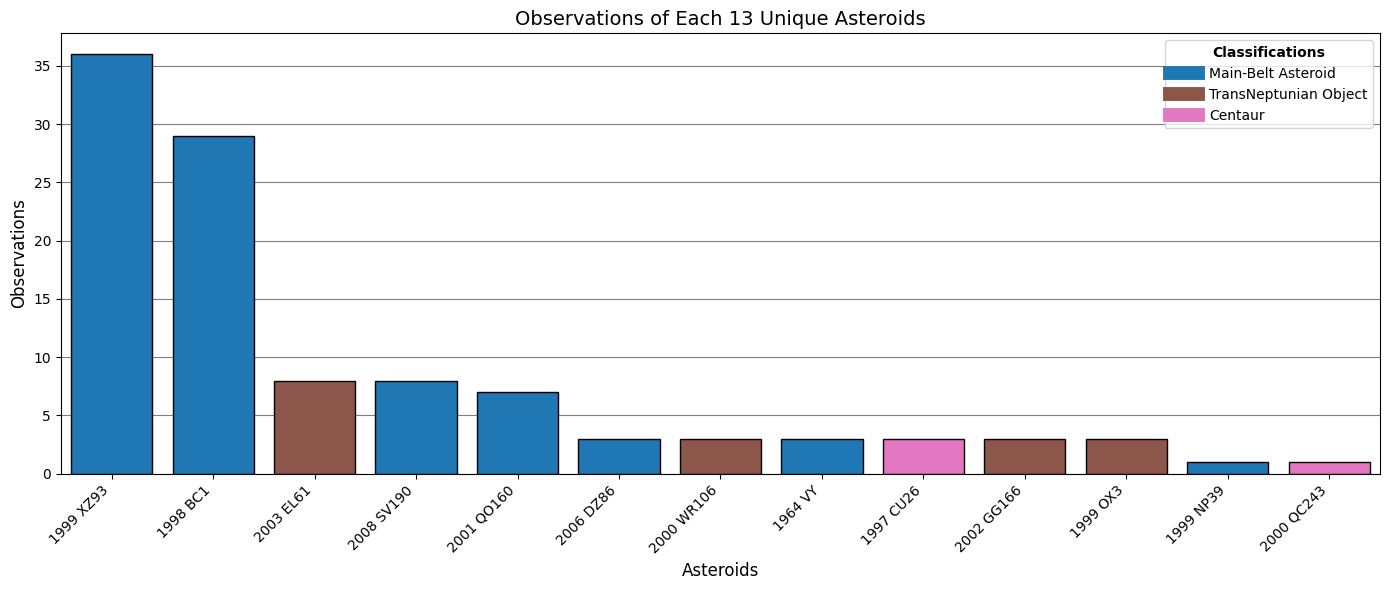

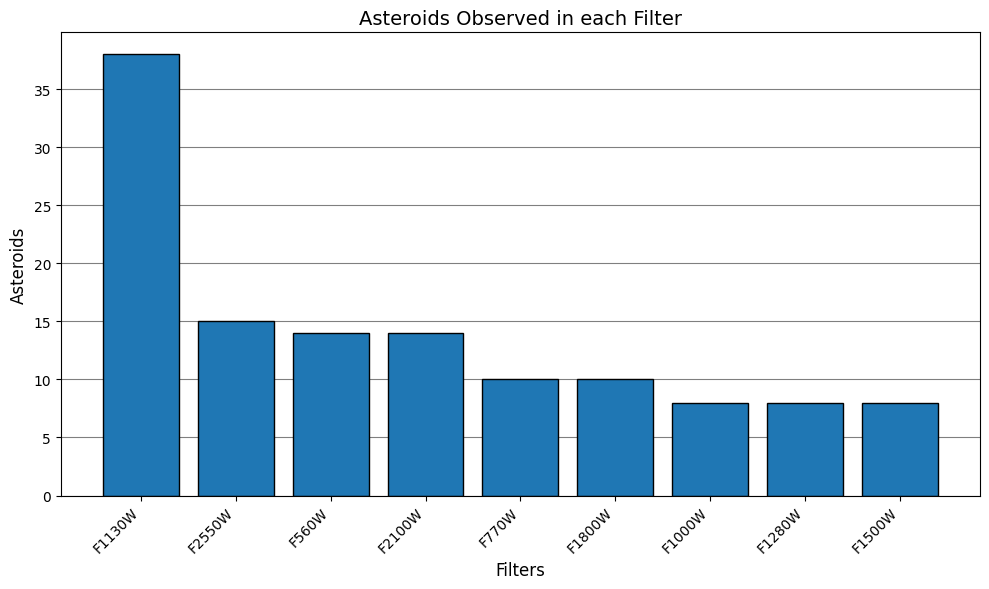

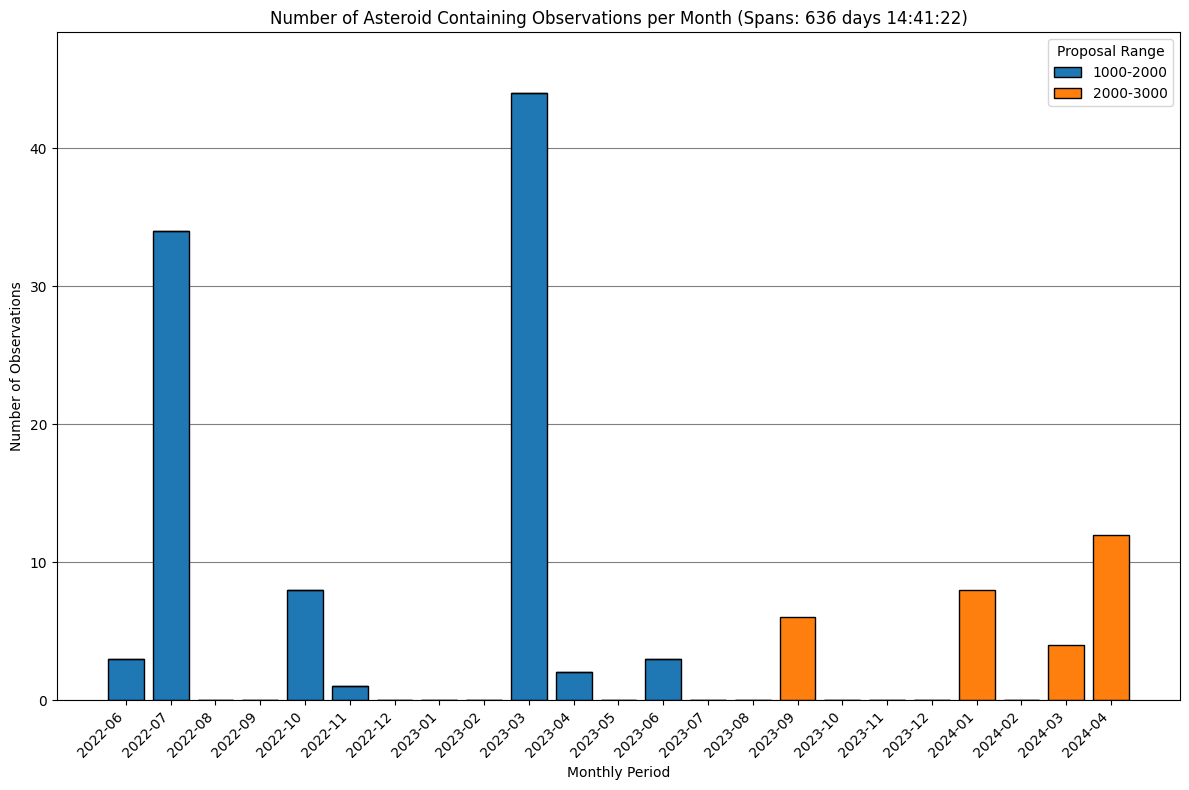

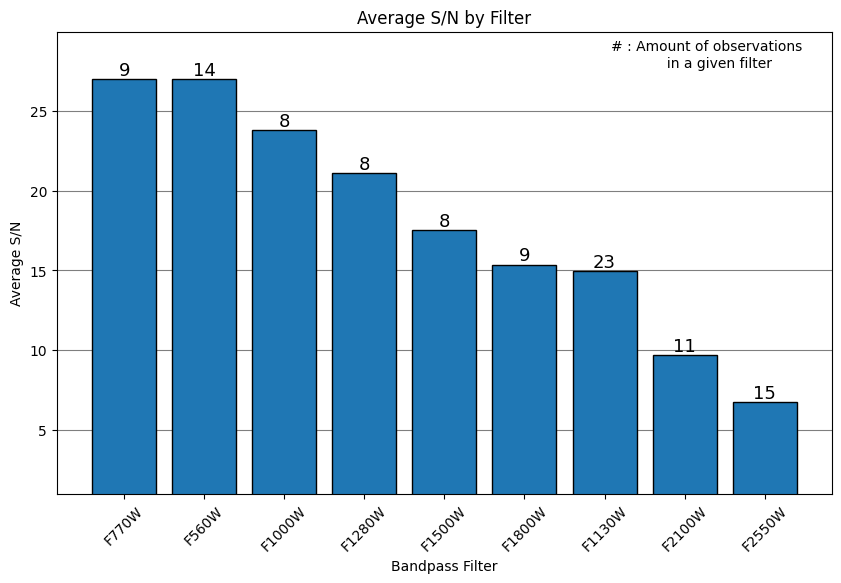

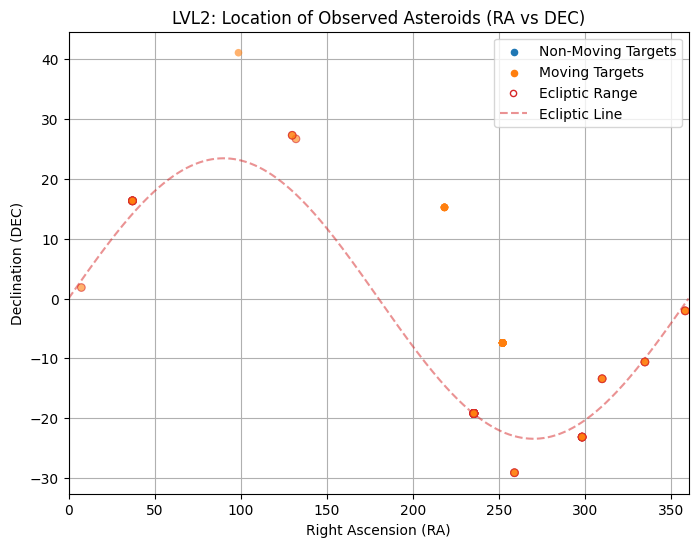

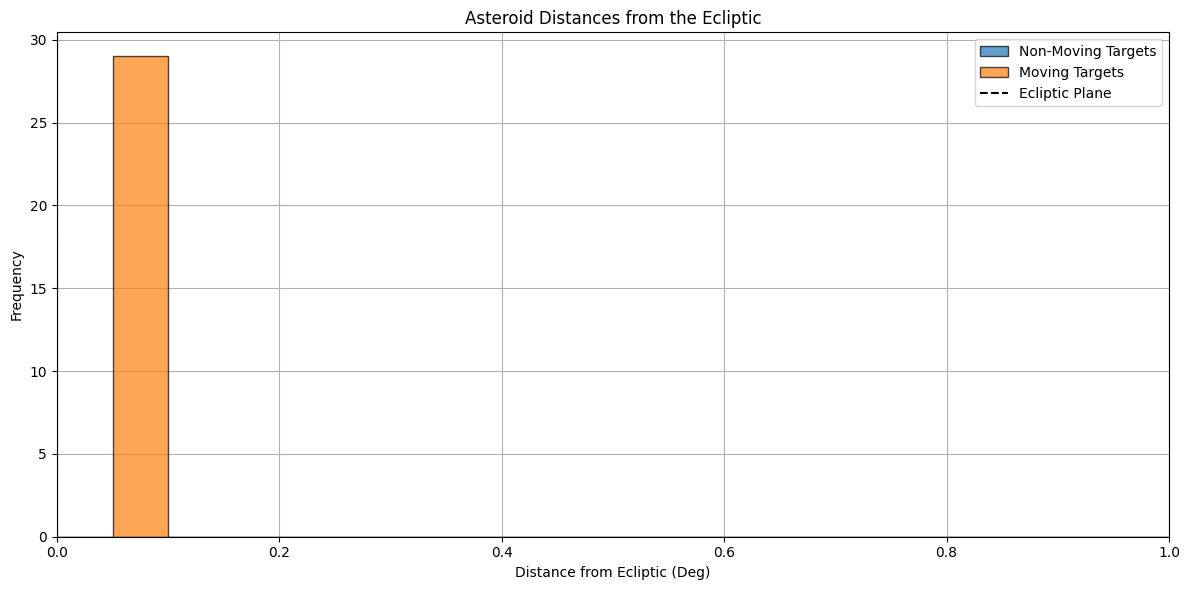

<Figure size 1200x600 with 0 Axes>

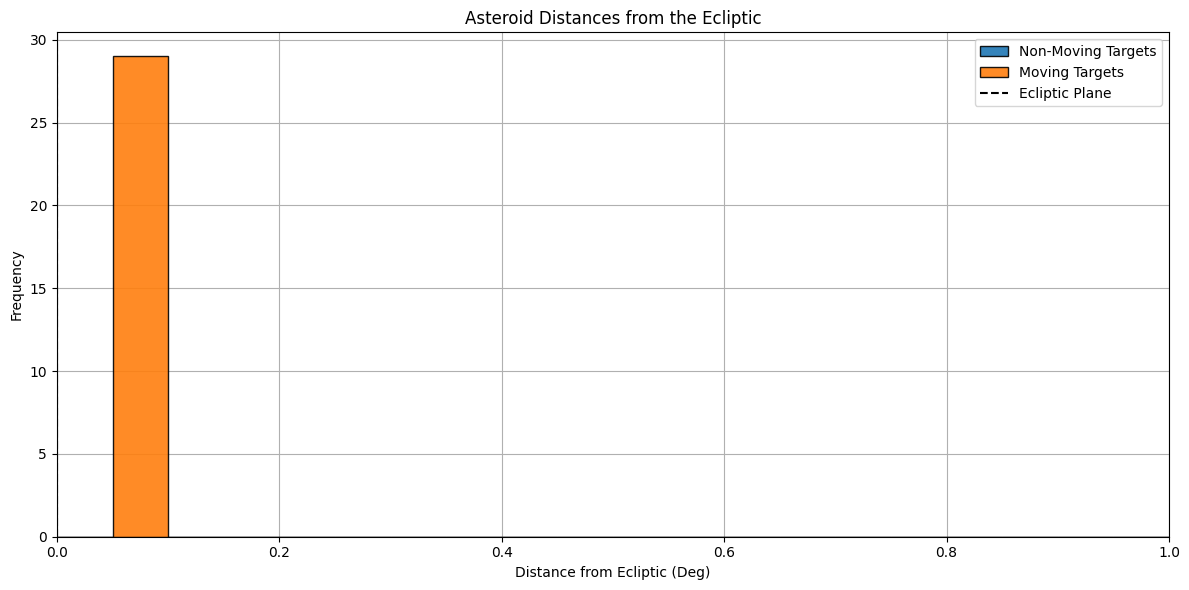

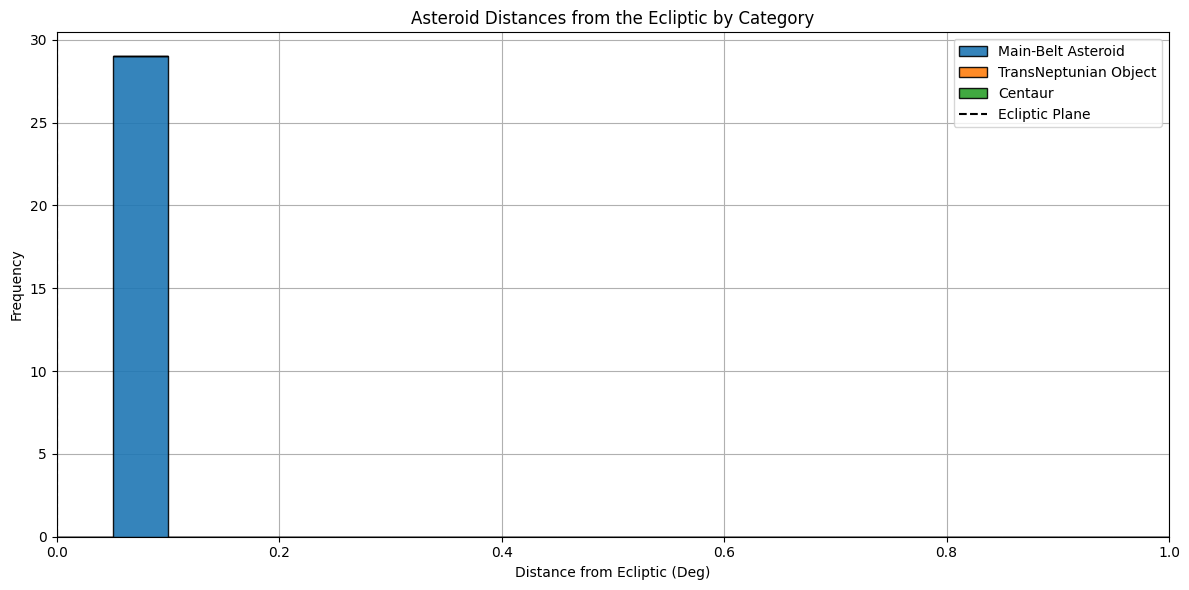

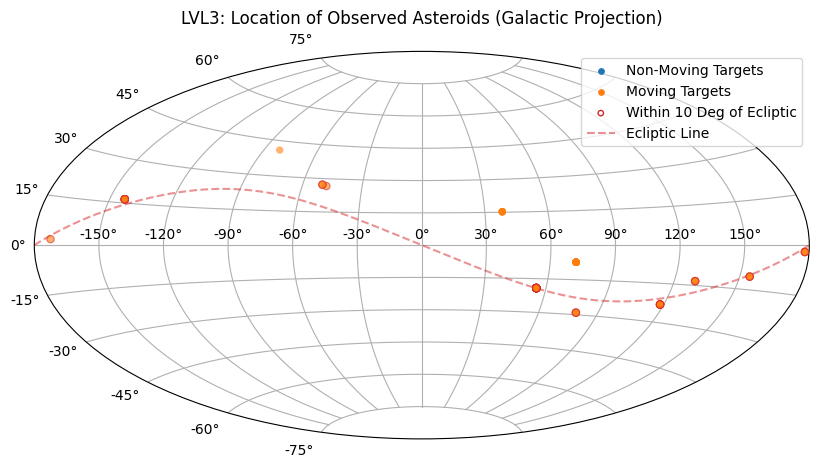

In [46]:
calLevel = 2
movingCheck = 'Yes'
Username = 'nmartind'
Password = 'Mr.Fantastic1999'

#main('LVL2/LVL2_Full.csv', calLevel, movingCheck) 
main(Username, Password, './LVL2_Full.csv', calLevel, movingCheck, 1000, 5000, 10)

The CSV contains a total of 3202 Observations (rows) from 293 unique proposals, of that 546 observations contain usable asteroid information, and 148 have no Datalabs information

Within the Proposal Range (1000 - 5000) there are 31561 total Level 2 Observations and 8219 Observations within 10 Degrees of the Ecliptic

Within the ecliptic range we have 438 Asteroid observations
Combining this with the total amount of observations, we find 1 measurable Asteroid in every 18.76 Observations
There are a total of 589 asteroid measurments from 74 unique asteroids from 438 asteroid containing observations, within ecliptic range 10
      Asteroid  Counts                                            Filters Proposals         Earliest Obs           Latest Obs           Time Diff              Classification Diameter Albedo
0    1999 XZ93      36  [F2550W, F2100W, F1800W, F1500W, F1280W, F1130...    [1522]  2023-03-21 15:00:36  2023-03-21 17:01:54             2:01:18          Main-Belt Asteroid    4.

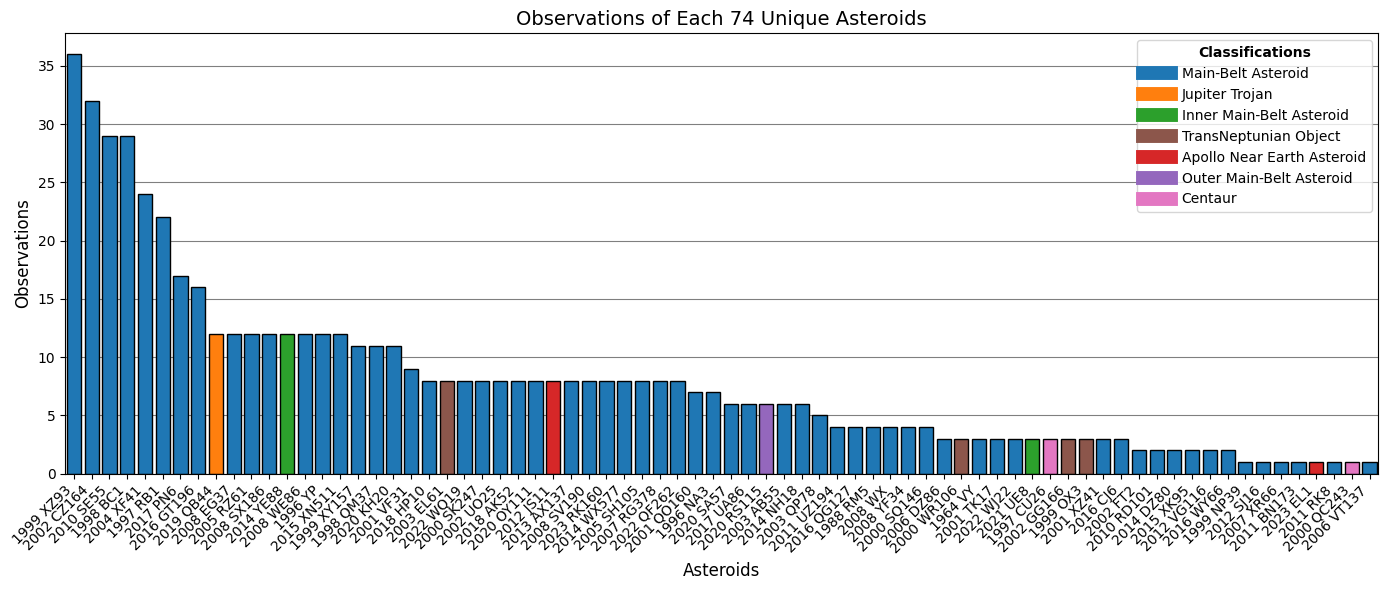

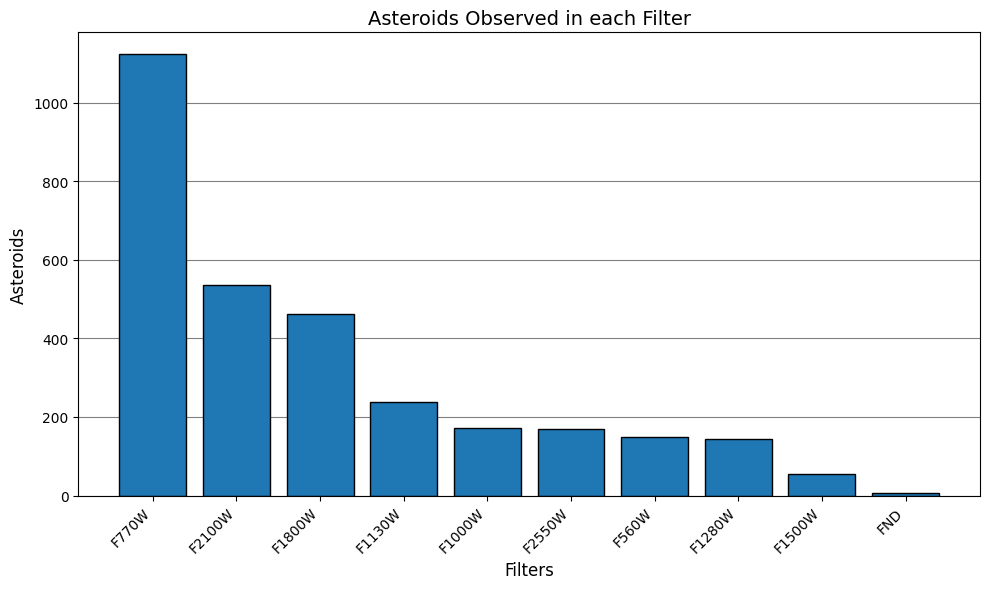

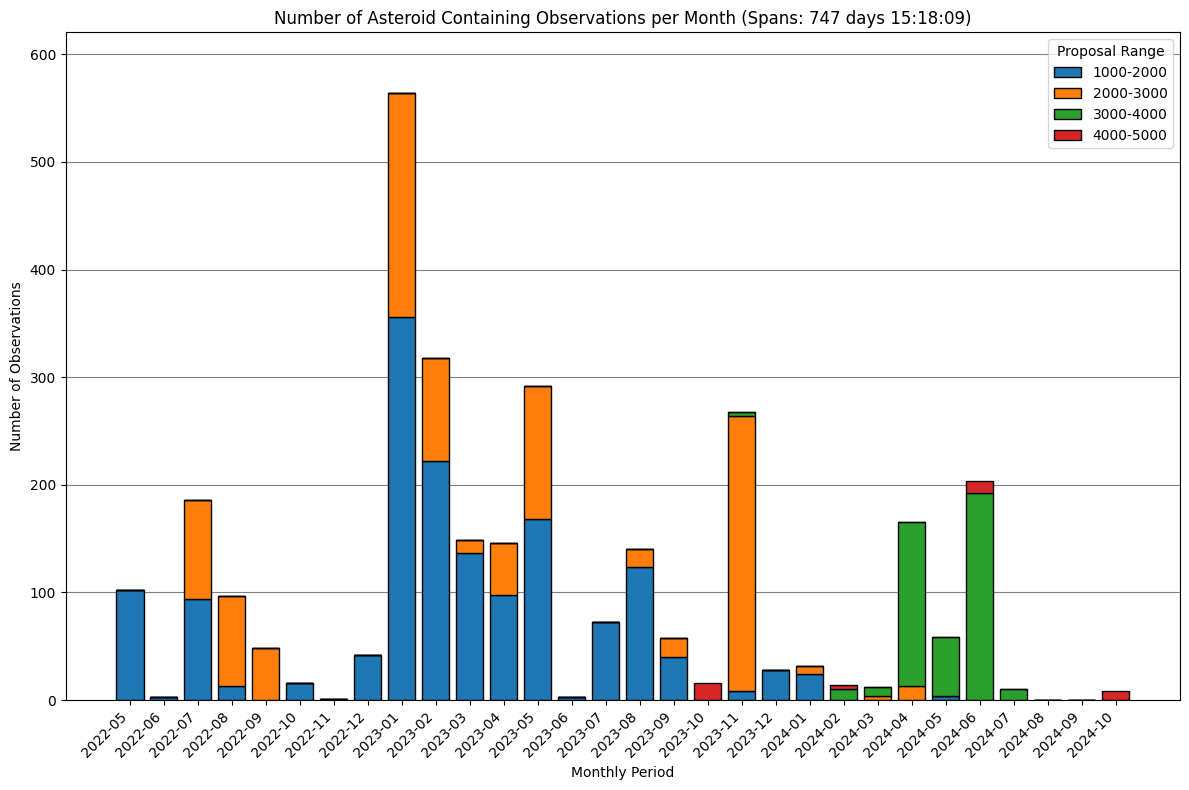

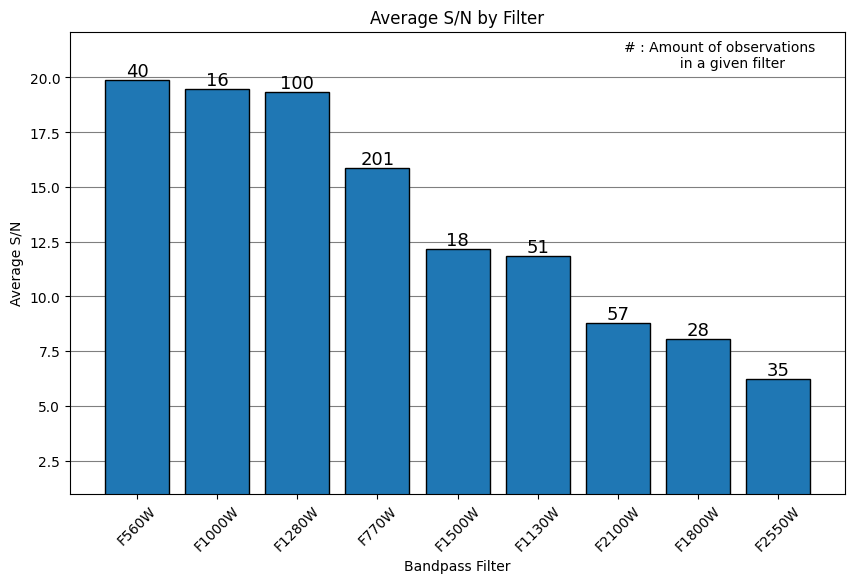

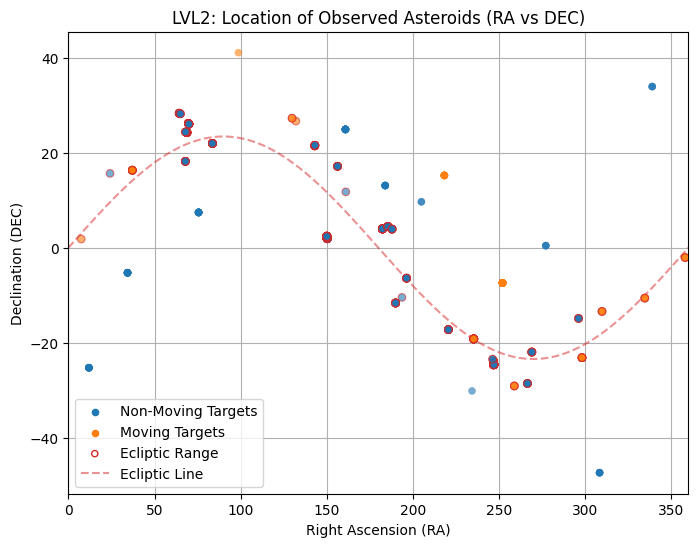

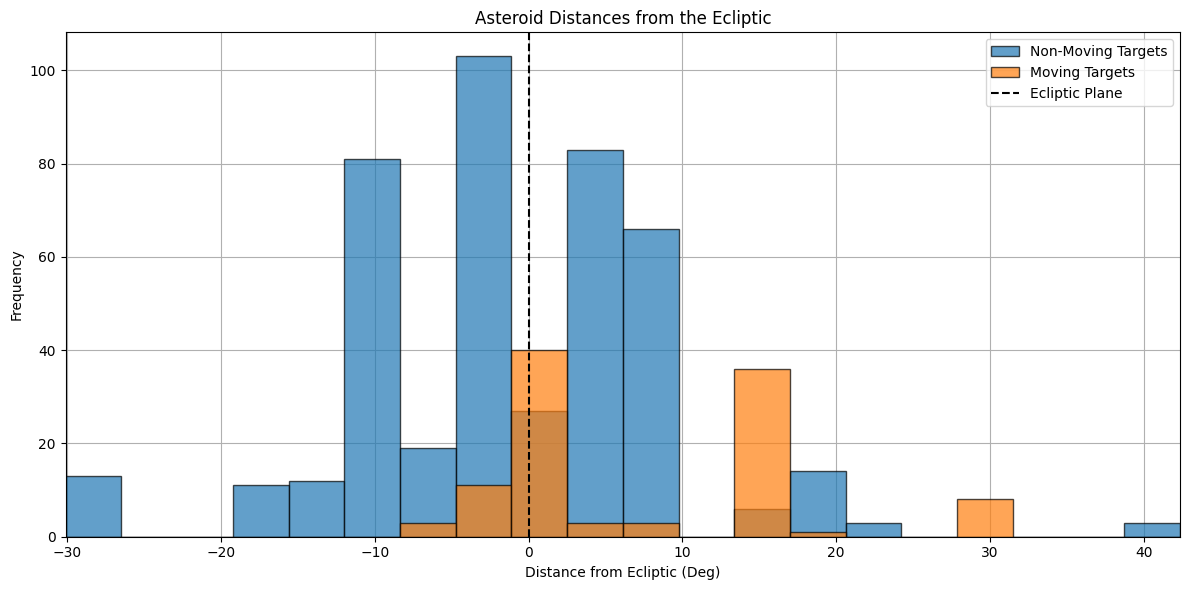

<Figure size 1200x600 with 0 Axes>

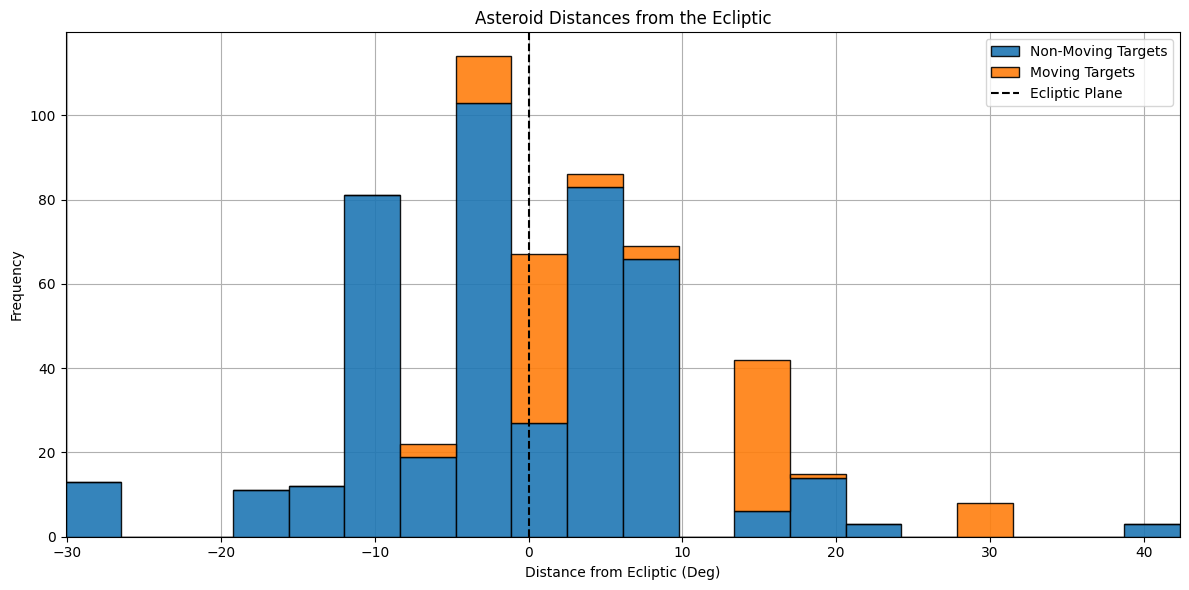

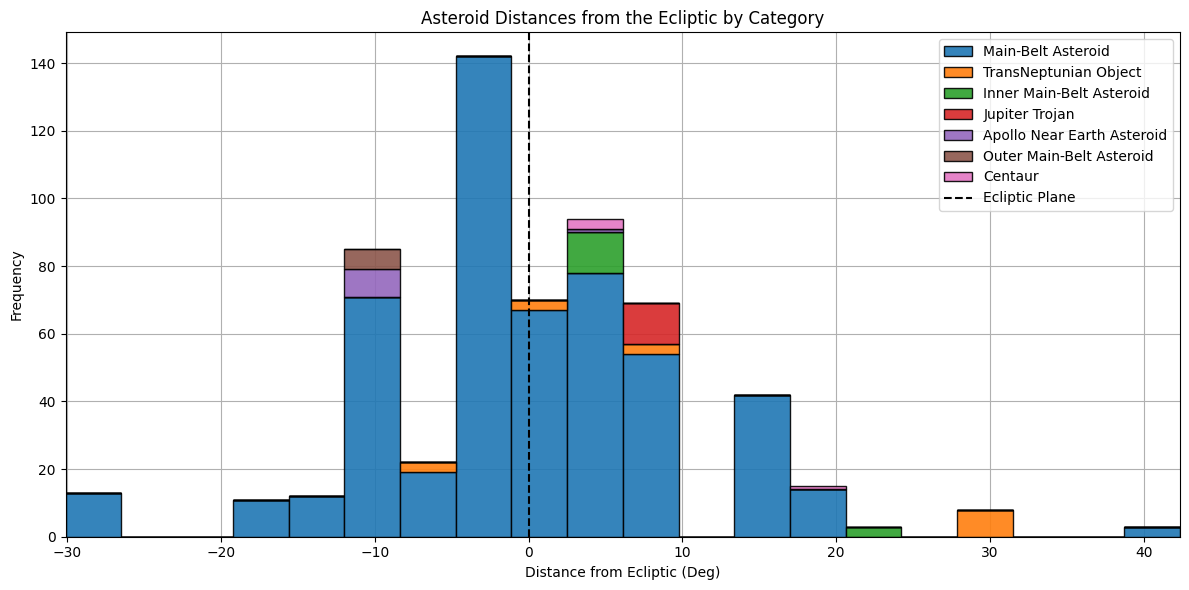

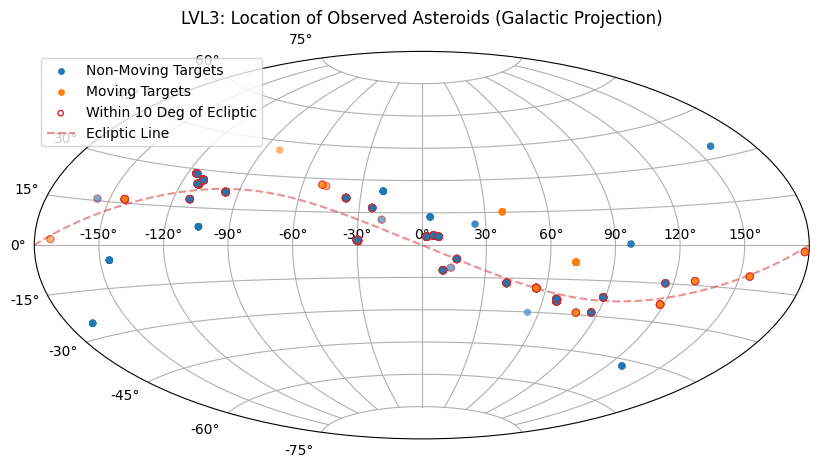

In [47]:
calLevel = 2
movingCheck = 'Both'
Username = 'nmartind'
Password = 'Mr.Fantastic1999'

#main('LVL2/LVL2_Full.csv', calLevel, movingCheck) 
main(Username, Password, './LVL2_Full.csv', calLevel, movingCheck, 1000, 5000, 10)

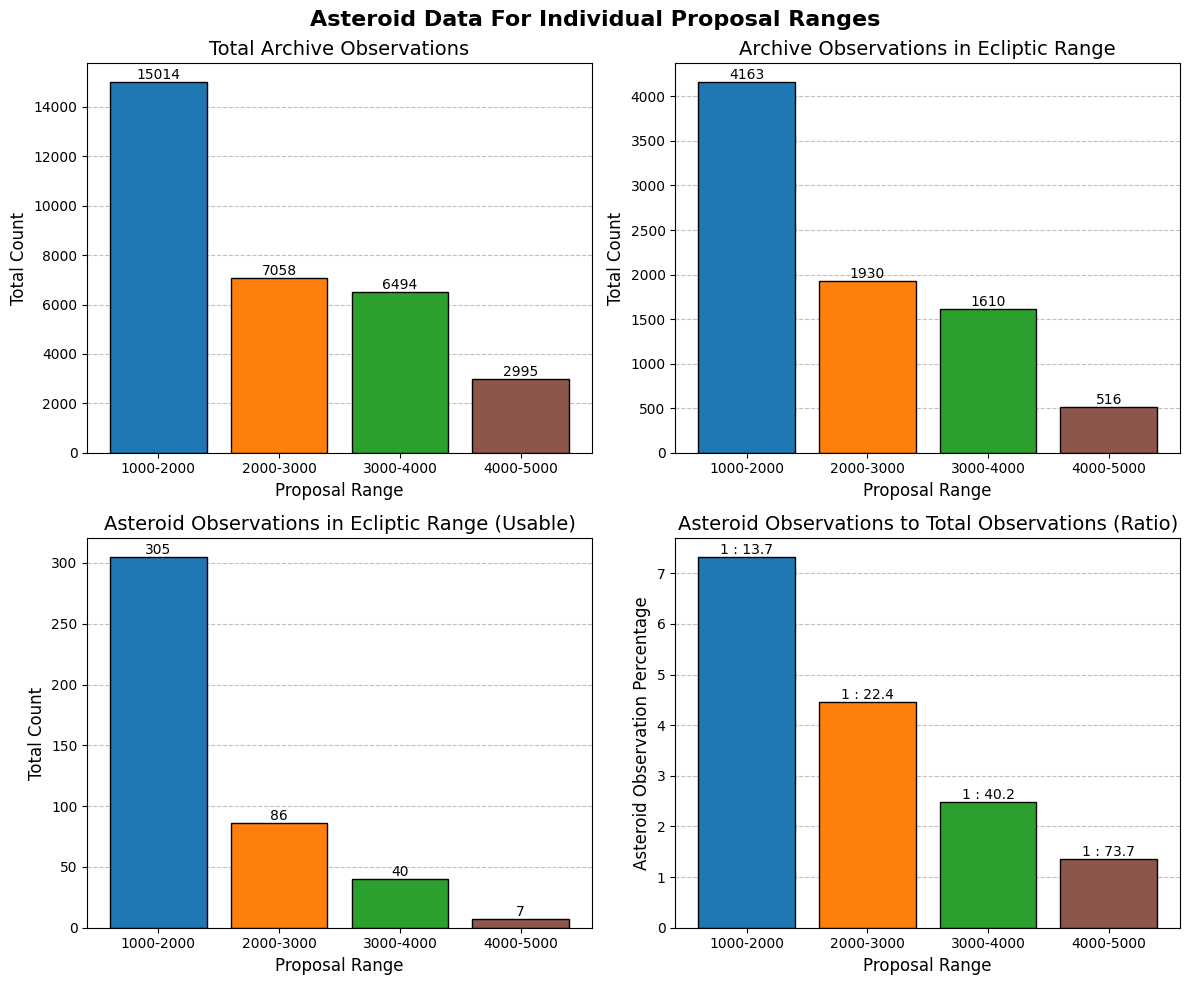

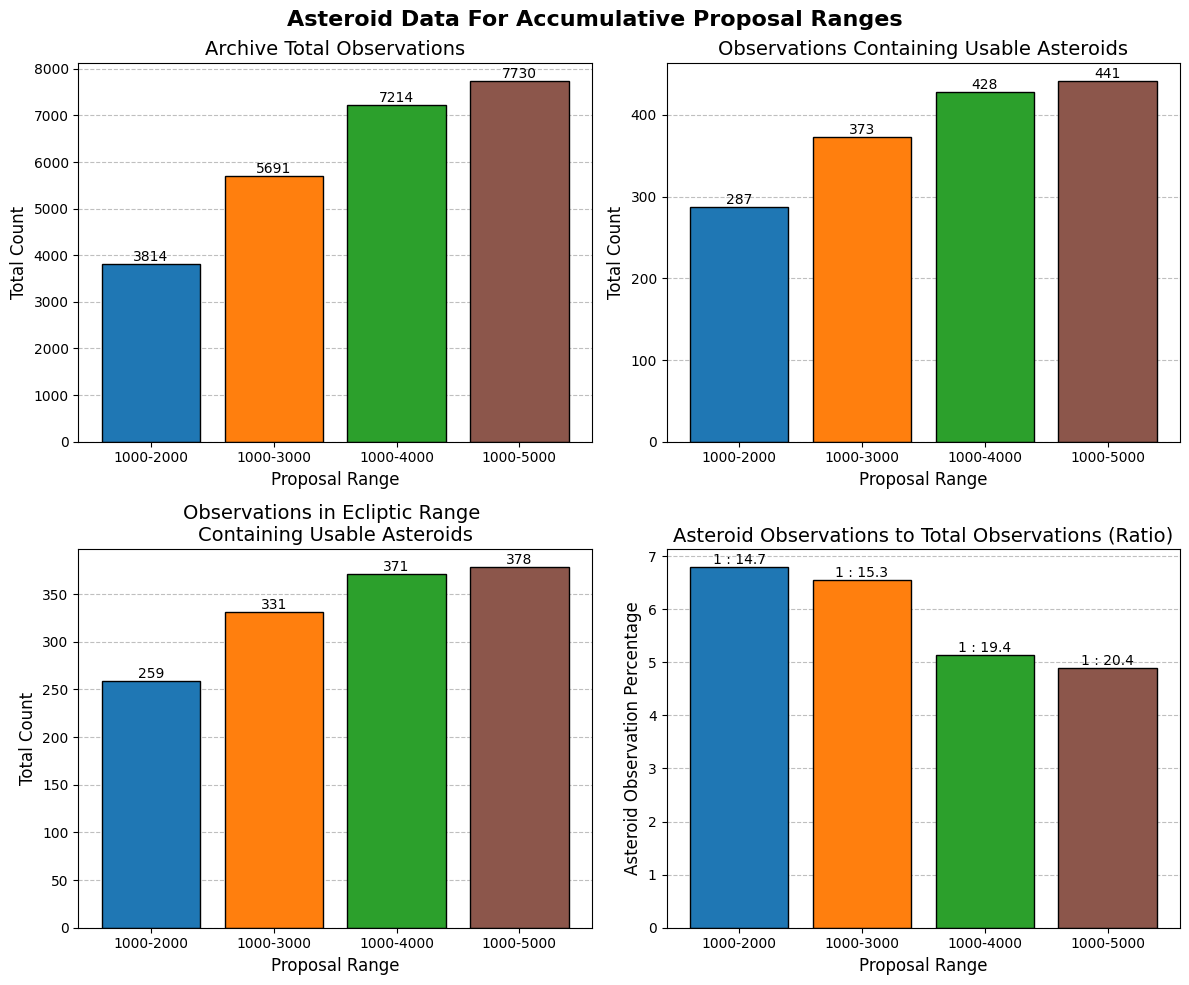

In [41]:
def asteroid_observation_progress_plots():
                   
    CSV_no_data = [2,35,99,12]

    # Data
    Range = ['1000-2000', '2000-3000', '3000-4000', '4000-5000']
    labels_dict = {
        'Total Archive Observations': [15014, 7058, 6494, 2995],
        'Archive Observations in Ecliptic Range': [4163, 1930, 1610, 516],
        'Asteroid Observations in Ecliptic Range (Usable)': [305, 86, 40, 7],
        'Asteroid Observations to Total Observations (Ratio)': [100/13.65, 100/22.44, 100/40.25, 100/73.71]
    }

    # Custom y-axis labels for each subplot
    y_labels = ['Total Count', 'Total Count', 'Total Count', 'Asteroid Observation Percentage']

    # Colors corresponding to the Range
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # Flatten the axes array for easier iteration
    
    plt.suptitle('Asteroid Data For Individual Proposal Ranges', fontsize=16, fontweight='bold')

    # Iterate over the dictionary to create the subplots
    for idx, (label, data) in enumerate(labels_dict.items()):
        ax = axes[idx]

        # X positions for the bars
        x_positions = np.arange(len(data))

        # Create the bar plot
        bars = ax.bar(x_positions, data, color=colors, edgecolor='black',zorder = 2)

        # Annotate each bar with its value
        for bar in bars:
            height = bar.get_height()
            if label == 'Asteroid Observations to Total Observations (Ratio)':
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
                    height,  # Y-coordinate (top of the bar)
                    f'1 : {(100/float(height)):.1f}' if isinstance(height, float) else f'{int(height)}',  # Text format
                    ha='center', va='bottom', fontsize=10, color='black'  # Text alignment and style
                )
            else:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
                    height,  # Y-coordinate (top of the bar)
                    f'{height:.2f}' if isinstance(height, float) else f'{int(height)}',  # Text format
                    ha='center', va='bottom', fontsize=10, color='black'  # Text alignment and style
                )

        # Set the title
        ax.set_title(label, fontsize=14)

        # Set x-ticks and labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(Range, rotation=0, fontsize=10)

        # Set y-axis label
        ax.set_ylabel(y_labels[idx], fontsize=12)

        # Add gridlines for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.8, zorder = 1)

        # Set the shared x-axis label
        ax.set_xlabel('Proposal Range', fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    print('\n\n')
       
    ###COMBINED STATS
    # Data
    Range = ['1000-2000', '1000-3000', '1000-4000', '1000-5000']
    labels_dict = {
        'Archive Total Observations': [3814, 5691, 7214, 7730],
        'Observations Containing Usable Asteroids': [287, 373, 428, 441],
        'Observations in Ecliptic Range \nContaining Usable Asteroids': [259, 331, 371, 378],
        'Asteroid Observations to Total Observations (Ratio)': [(100/14.73), (100/15.26), (100/19.44), (100/20.45)]
    }

    # Custom y-axis labels for each subplot
    y_labels = ['Total Count', 'Total Count', 'Total Count', 'Asteroid Observation Percentage']

    # Colors corresponding to the Range
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Iterate over the dictionary to create the subplots
    for idx, (label, data) in enumerate(labels_dict.items()):
        ax = axes[idx]

        # X positions for the bars
        x_positions = np.arange(len(data))

        # Create the bar plot
        bars = ax.bar(x_positions, data, color=colors, edgecolor='black', zorder=2)

        # Annotate each bar with its value
        for bar in bars:
            height = bar.get_height()
            if label == 'Asteroid Observations to Total Observations (Ratio)':
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
                    height,  # Y-coordinate (top of the bar)
                    f'1 : {(100/float(height)):.1f}' if isinstance(height, float) else f'{int(height)}',  # Text format
                    ha='center', va='bottom', fontsize=10, color='black'  # Text alignment and style
                )
            else:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
                    height,  # Y-coordinate (top of the bar)
                    f'{height:.2f}' if isinstance(height, float) else f'{int(height)}',  # Text format
                    ha='center', va='bottom', fontsize=10, color='black'  # Text alignment and style
                )

        # Set the title
        ax.set_title(label, fontsize=14)

        # Set x-ticks and labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(Range, rotation=0, fontsize=10)

        # Set y-axis label
        ax.set_ylabel(y_labels[idx], fontsize=12)

        # Add gridlines for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.8)

        # Set the shared x-axis label
        ax.set_xlabel('Proposal Range', fontsize=12)

    plt.suptitle('Asteroid Data For Accumulative Proposal Ranges', fontsize=16, fontweight='bold')
        
    # Adjust layout to prevent overlap
    plt.tight_layout()
    

    # Show the plot
    plt.show()
    
    
asteroid_observation_progress_plots()    

352
7.326447273600769 0.048042277203939464
4.455958549222798 1.8134715025906734
2.484472049689441 6.149068322981367
1.3565891472868217 2.3255813953488373
9.926447273600768


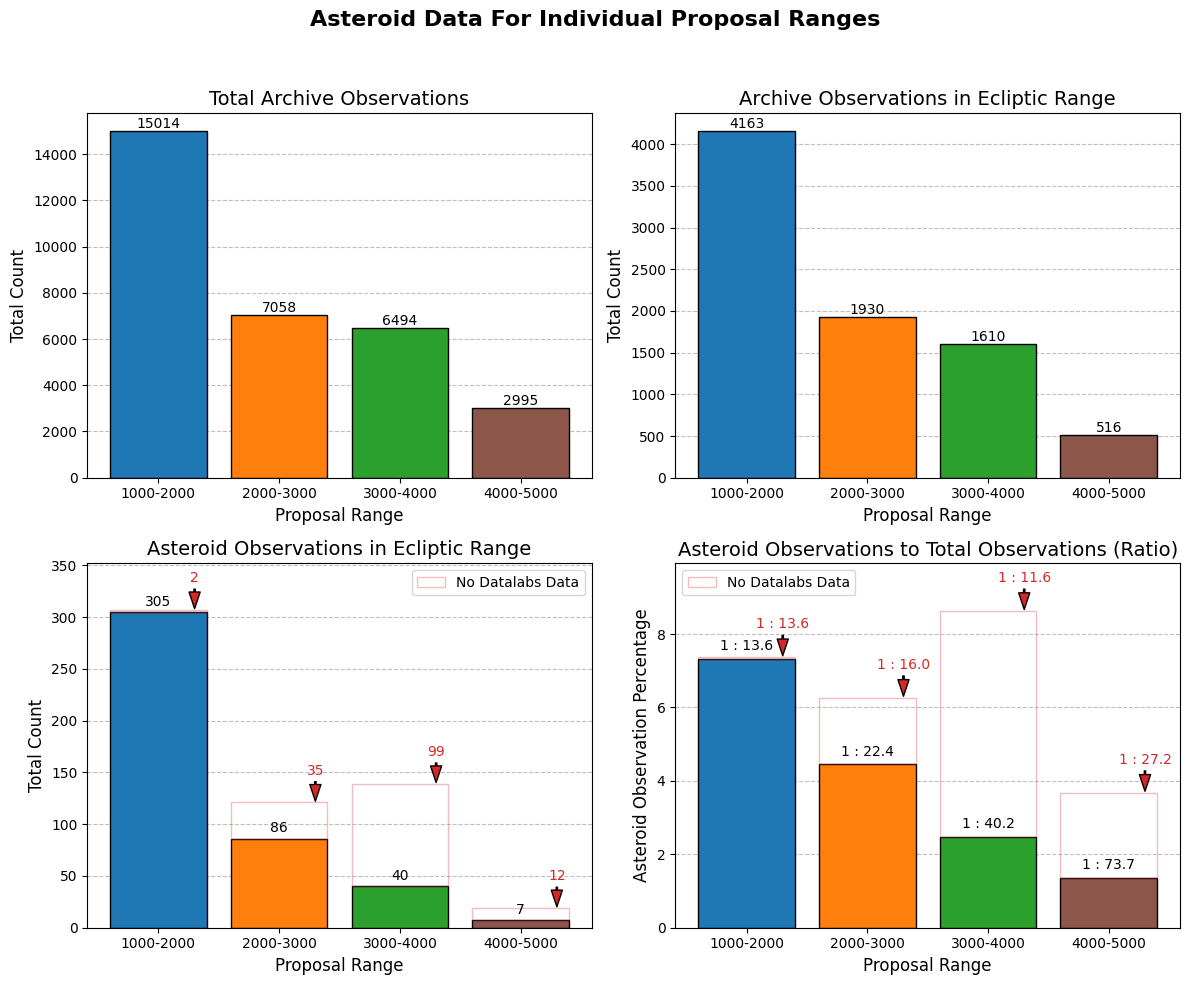

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Data
Range = ['1000-2000', '2000-3000', '3000-4000', '4000-5000']
CSV_no_data = [2, 35, 99, 12]
CSV_no_data_frac = [100*(2 / 4163), 100*(35 / 1930), 100*(99 / 1610), 100*(12 / 516)]
CSV_no_data_ratio = [4163/307, 1930/121, 1610/139, 516/19]


labels_dict = {
    'Total Archive Observations': [15014, 7058, 6494, 2995],
    'Archive Observations in Ecliptic Range': [4163, 1930, 1610, 516],
    'Asteroid Observations in Ecliptic Range': [305, 86, 40, 7],
    'Asteroid Observations to Total Observations (Ratio)': [100*(305 / 4163), 100*(86 / 1930), 100*(40 / 1610), 100*(7 / 516)],
}

# Custom y-axis labels for each subplot
y_labels = ['Total Count', 'Total Count', 'Total Count', 'Asteroid Observation Percentage']

# Colors corresponding to the Range
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

plt.suptitle('Asteroid Data For Individual Proposal Ranges', fontsize=16, fontweight='bold')

maxheight = 0

# Iterate over the dictionary to create the subplots
for idx, (label, data) in enumerate(labels_dict.items()):
    ax = axes[idx]

    # X positions for the bars
    x_positions = np.arange(len(data))

    if label == 'Asteroid Observations in Ecliptic Range':
        # Create stacked bar chart for the third subplot
        bars_base = ax.bar(x_positions, data, color=colors, edgecolor='black', zorder=2)
        bars_stack = ax.bar(x_positions, CSV_no_data, bottom=data, facecolor='none', edgecolor='tab:red', alpha=0.3, zorder=2, label='No Datalabs Data')

        # Annotate the base bars and red bars
        for i in range(len(data)):
            if maxheight < data[i] + 47:
                maxheight = data[i] + 47
            # Base bar annotation
            ax.text(
                x_positions[i],
                data[i] +10,  # Positioning for base bar
                f'{data[i]}',
                ha='center', va='center', fontsize=10, color='black'
            )
            # Red bar annotation
            ax.annotate(
                f'{CSV_no_data[i]}',  # Text
                xy=(x_positions[i]+0.3, data[i] + CSV_no_data[i]),  # Arrowhead position
                xytext=(x_positions[i]+0.3, data[i] + CSV_no_data[i] + 24),  # Text position above
                arrowprops=dict(facecolor='tab:red', shrink=0.05, width=1, headwidth=8),
                ha='center', va='bottom', fontsize=10, color='tab:red'
            )
            
    elif label == 'Asteroid Observations to Total Observations (Ratio)':
        # Create stacked bar chart for the third subplot
        bars_base = ax.bar(x_positions, data, color=colors, edgecolor='black', zorder=2)
        bars_stack = ax.bar(x_positions, CSV_no_data_frac, bottom=data, facecolor='none', edgecolor='tab:red', alpha=0.3, zorder=2, label='No Datalabs Data')
        
        # Annotate the base bars and red bars
        for i in range(len(data)):
            if maxheight < data[i] + 2.6:
                maxheight = data[i] +2.6
            # Base bar annotation
            ax.text(
                    x_positions[i],  # X-coordinate (center of the bar)
                    data[i] +0.15,  # Y-coordinate (top of the bar)
                    f'1 : {(100 / float(data[i])):.1f}' if isinstance(data[i], float) else f'{int(data[i])}',  # Text format
                    ha='center', va='bottom', fontsize=10, color='black'  # Text alignment and style
                )
            # Red bar annotation
            print(data[i], CSV_no_data_frac[i])
            ax.annotate(
                f'1 : {CSV_no_data_ratio[i]:.1f}',  # Text
                xy=(x_positions[i]+0.3, data[i] + CSV_no_data_frac[i]),  # Arrowhead position
                xytext=(x_positions[i]+ 0.3, data[i] + CSV_no_data_frac[i]+0.7),  # Text position above
                arrowprops=dict(facecolor='tab:red', shrink=0.05, width=1, headwidth=8),
                ha='center', va='bottom', fontsize=10, color='tab:red'
            )
            
        
    else:
        # Create the bar plot for other subplots
        bars = ax.bar(x_positions, data, color=colors, edgecolor='black', zorder=2)

        # Annotate each bar with its value
        for bar in bars:
            height = bar.get_height()
        
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
                height,  # Y-coordinate (top of the bar)
                f'{height:.2f}' if isinstance(height, float) else f'{int(height)}',  # Text format
                ha='center', va='bottom', fontsize=10, color='black'  # Text alignment and style
            )
    
    if maxheight != 0:
        print(maxheight)
        ax.set_ylim(0,maxheight)
        maxheight = 0
    
    # Set the title
    ax.set_title(label, fontsize=14)

    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(Range, rotation=0, fontsize=10)

    # Set y-axis label
    ax.set_ylabel(y_labels[idx], fontsize=12)

    # Add gridlines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.8, zorder=1)

    # Set the shared x-axis label
    ax.set_xlabel('Proposal Range', fontsize=12)

# Add legend to the third subplot
axes[2].legend()
axes[3].legend()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()